# Predicting Cuphead Bosses from Keystroke Data

## 1. Introduction / The Dataset
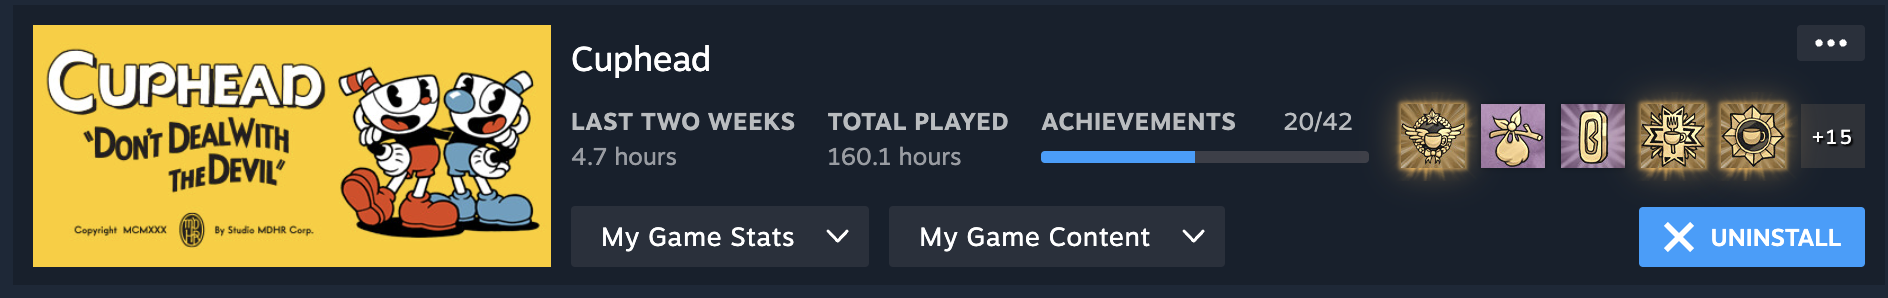
According to Steam, I've spent 160.1 hours playing Cuphead (wow!). The game is a series of unique boss battles, each demanding a different strategy. So I thought it would be fun to see if my own unconscious gameplay patterns are distinct enough for a machine to tell the bosses apart.

The data for this project is a **personal archive of my keystroke recordings from 240 fight attempts against four specific bosses (60 fights each)**: Cagney Carnation, Grim Matchstick, Baroness Von Bon Bon, and Glumstone the Giant.


### How the Data Was Obtained and Sampled

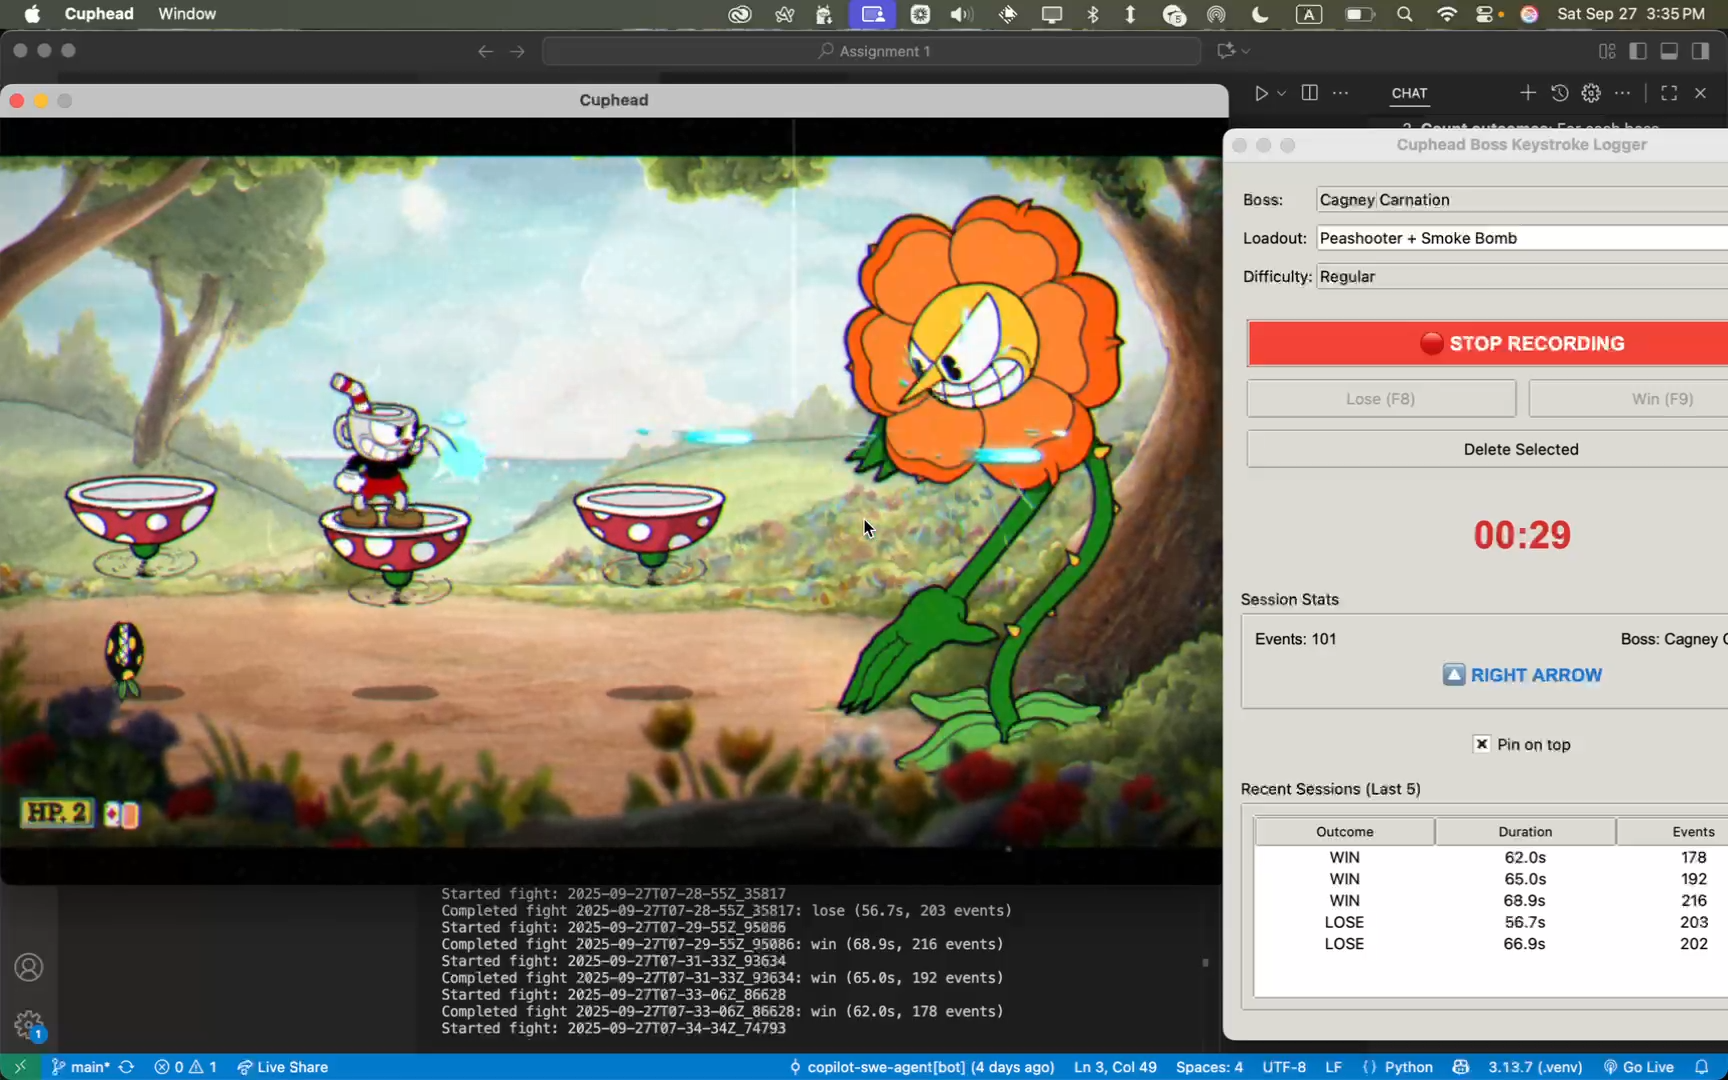

To capture this, I developed a custom Python application using `Tkinter` for the UI and `pynput` for keyboard listening. The tool used global hotkeys to precisely mark the start and end of each fight, ensuring a clean and consistent dataset.

 Each session was saved as a **JSON Lines (.jsonl)** file containing metadata (loadout and difficulty are fixed), a full stream of timestamped keydown and keyup events, and a final summary of the outcome and duration. More details on the logger's design and data quality features can be found in Appendix A.

 As the data comes entirely from my own playtime, it represents a convenience sample. 

 [Keystorke logger code base (Github)](https://github.com/ddanakim0304/CS156-Assignment-1) - detailed code explanation in Appendix B


**Sample Log Structure:**

[View All the Raw Logs on GitHub](https://github.com/ddanakim0304/CS156-Assignment-1/blob/main/data/raw/2025-09-23T13-52-06Z_26962.jsonl)

In [67]:
{"meta": {"boss": "Cagney Carnation", "loadout": "Peashooter + Smoke Bomb", "difficulty": "Regular", "start_utc": "2025-09-23T13-52-06.960065+00:00"}}
{"event": "keydown", "key": "f", "t_ms": 1476}
...
{"event": "keydown", "key": "Key.space", "t_ms": 4038}
{"event": "keyup", "key": "Key.space", "t_ms": 4054}
{"summary": {"outcome": "win", "duration_ms": 74788, "end_utc": "2025-09-23T13:53:21.751994+00:00"}}

{'summary': {'outcome': 'win',
  'duration_ms': 74788,
  'end_utc': '2025-09-23T13:53:21.751994+00:00'}}

### 2. Loading the Raw Data

The raw `.jsonl` logs are just streams of events, so I transformed this sequence into a structured tabular format. I chose `pandas` for this because it provides the suitable data structure (DataFrame) and a toolkit of fast operations (.groupby, filtering, etc) that are the industry standard for cleaning and transforming data for machine learning.

#### Data Cleaning

1. Because I started and stopped the logger manually with a hotkey, there's a human-sized delay between when the fight actually starts on screen and when I hit the record button. So, I've adjusted all the timestamps to start at t_ms = 0 from the very first action in each log.

2. I also had to discard any accidental recordings; any fight lasting less than 5 seconds or with fewer than 10 key presses is deleted.

3. Finally, to ensure my dataset is perfectly balanced for the classification task, I took a random sample of 60 fights for each of the four bosses

In [68]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob

# Import Machine Learning Libraries
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import clone
from scipy.sparse import vstack as sparse_vstack

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Set a random seed for reproducibility of the sampling
np.random.seed(34) # my birthday

In [69]:
# 1. Load All Raw Data
data_path = '../data/raw/*.jsonl'
files = glob.glob(data_path)
all_events_data = []

# Iterate through each file and extract event data
for file_path in files:
    with open(file_path, 'r') as f:
        # Read all lines from the file
        lines = f.readlines()
        if not lines: continue
        try:
            meta_data = json.loads(lines[0])['meta']
            fight_id = json.loads(lines[0])['fight_id']
            boss_name = meta_data.get('boss')
            for line in lines[1:-1]:
                event_data = json.loads(line)
                if 'event' in event_data:
                    all_events_data.append({
                        'fight_id': fight_id, 'boss': boss_name,
                        'event': event_data['event'], 'key': event_data['key'],
                        't_ms': event_data['t_ms']
                    })
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Skipping malformed file: {file_path}")

# Convert the list of event data into a DataFrame
raw_df = pd.DataFrame(all_events_data)
print(f"Loaded a total of {raw_df['fight_id'].nunique()} fights initially.")


# 2. Adjust Timestamps
first_action_times = raw_df.groupby('fight_id')['t_ms'].transform('min')
clean_df = raw_df.copy()
# Subtract the first action time from all timestamps in that fight to normalize them
clean_df['t_ms'] = clean_df['t_ms'] - first_action_times
print("Normalized all fight timestamps to start at t_ms = 0 from the first action.")


# 3. Filter Out Accidental Recordings
fight_stats = clean_df.groupby('fight_id')['t_ms'].agg(
    event_count='count', 
    duration_ms='max'
)
# Identify the IDs of fights that are long enough and have enough events
valid_fight_ids = fight_stats[
    (fight_stats['event_count'] >= 10) & 
    (fight_stats['duration_ms'] >= 5000)
].index
# Filter the main DataFrame to keep only valid fights
clean_df = clean_df[clean_df['fight_id'].isin(valid_fight_ids)]
print(f"Filtered down to {len(valid_fight_ids)} valid fights (>=10 events and >=10s duration).")

all_sampled_ids = []

# Get unique fight IDs along with their corresponding boss names
valid_fights_with_boss = clean_df[['fight_id', 'boss']].drop_duplicates()

for boss_name in valid_fights_with_boss['boss'].unique():
    # Get all valid fight IDs for the current boss
    boss_fight_ids = valid_fights_with_boss[valid_fights_with_boss['boss'] == boss_name]['fight_id'].unique()
    
    # Print the count before sampling
    total_fights_for_boss = len(boss_fight_ids)
    print(f"- {boss_name}: 60 fights chosen out of {total_fights_for_boss} fights")
    
    # Randomly choose 60 IDs from this boss's pool
    sampled_boss_ids = np.random.choice(boss_fight_ids, size=60, replace=False)
    
    # Add these sampled IDs to the overall list
    all_sampled_ids.extend(sampled_boss_ids)

# Filter the main DataFrame to keep only the 240 sampled fights
final_df = clean_df[clean_df['fight_id'].isin(all_sampled_ids)].reset_index(drop=True)

print(f"\nFinal balanced dataset contains {final_df['fight_id'].nunique()} fights.")
final_df.head(10)

Loaded a total of 278 fights initially.
Normalized all fight timestamps to start at t_ms = 0 from the first action.
Filtered down to 277 valid fights (>=10 events and >=10s duration).
- Glumstone the Giant: 60 fights chosen out of 82 fights
- Baroness Von Bon Bon: 60 fights chosen out of 60 fights
- Cagney Carnation: 60 fights chosen out of 74 fights
- Grim Matchstick: 60 fights chosen out of 61 fights

Final balanced dataset contains 240 fights.


fight_id                 boss    event       key  t_ms
0  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown         f     0
1  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown  Key.down    45
2  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup  Key.down   332
3  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup         f   403
4  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown  Key.down   543
5  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown         f   544
6  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup  Key.down  1334
7  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup         f  1410
8  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown  Key.down  1454
9  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown         f  2130

### 3. Pre-processing and Feature Engineering

With the clean event data loaded, the next step is to transform it into a machine-learnable feature matrix. Before boiling everything down to a few numbers, I wanted to actually *see* what the gameplay rhythm looks like. To do this, I created a Keystroke Timeline plot, which visualizes every single key press in a fight on a timeline, with the length of each bar showing exactly how long I held the button down.

I selected my longest successful ('win') attempt for this visualization. For Glumstone the Giant, where I didn't have a 'win' log in my sampled data, I chose my longest attempt to see the pattern.

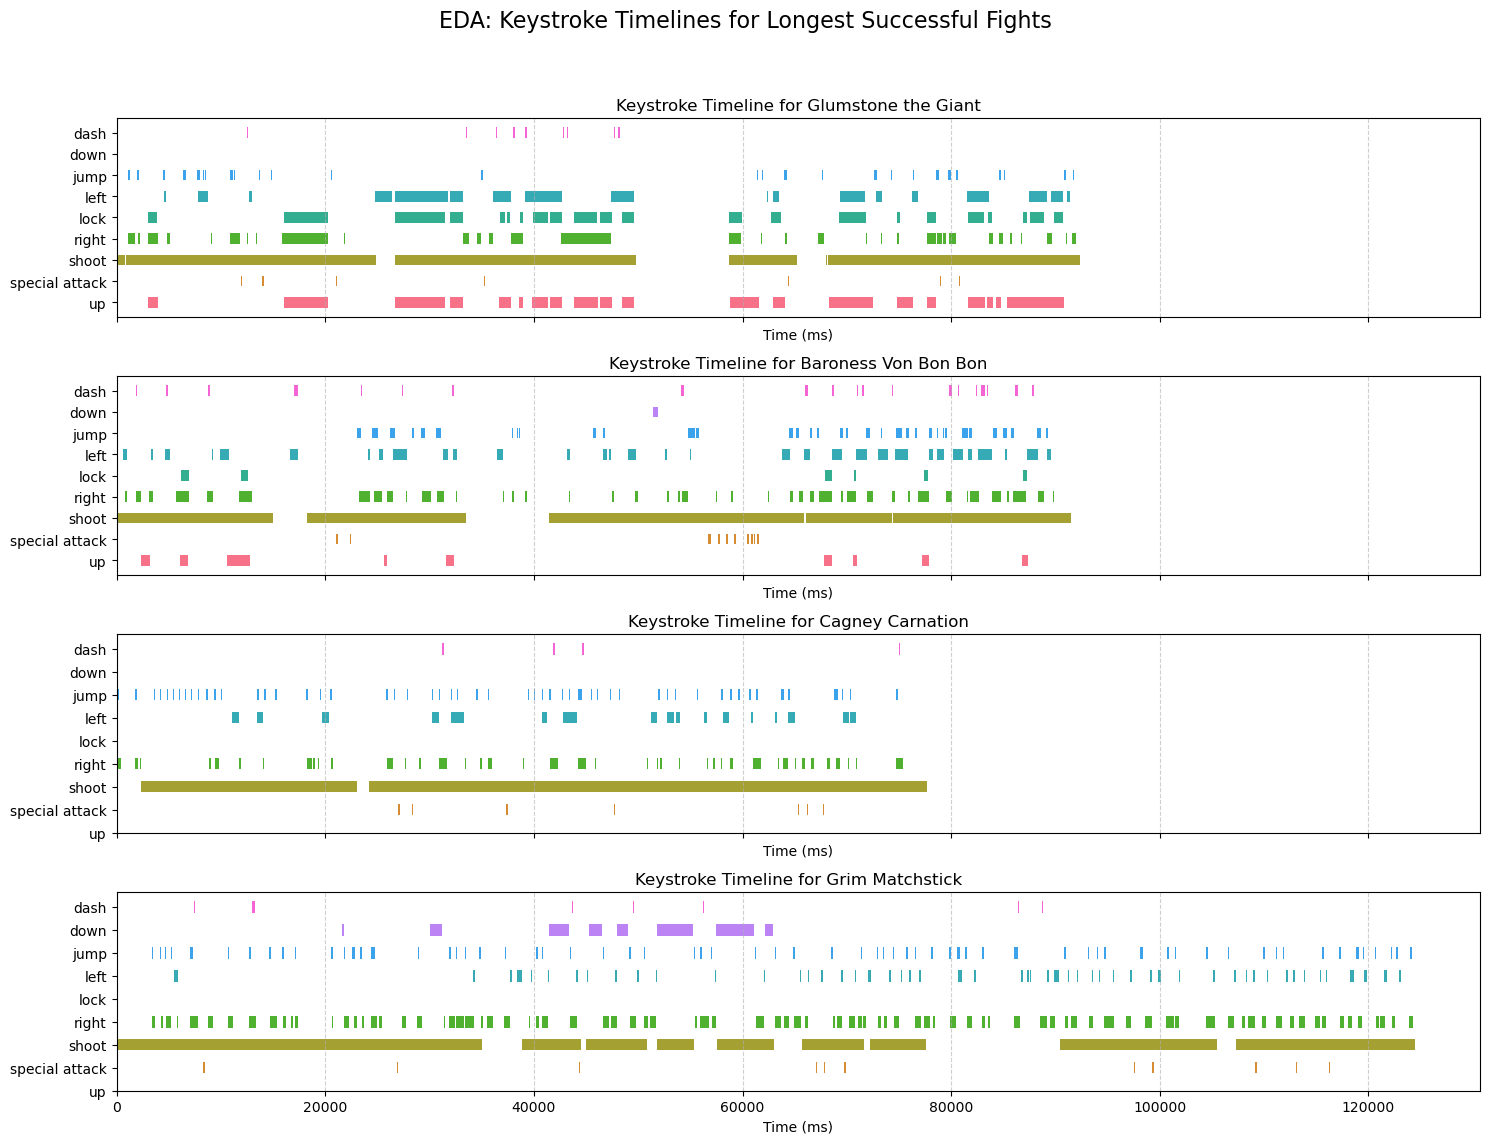

In [70]:
# 1. Pre-processing: Standardize Action Names
key_mapping = {
    'Key.space': 'jump', 'f': 'shoot', 'd': 'dash', 'x': 'lock',
    'a': 'special attack', 'Key.up': 'up', 'Key.down': 'down', 'Key.left': 'left', 'Key.right': 'right'
}
processed_df = final_df.copy()
processed_df['action'] = processed_df['key'].map(key_mapping)
# Drop any events that weren't in the mapping
processed_df.dropna(subset=['action'], inplace=True)


# EDA: Visualizing the Raw Keystroke Timeline
# Gather fight outcomes and durations from the summary lines
fight_outcomes = {}
for file_path in glob.glob('../data/raw/*.jsonl'):
    fight_id = file_path.split('/')[-1].replace('.jsonl', '')
    with open(file_path, 'r') as f:
        try:
            last_line = f.readlines()[-1]
            summary = json.loads(last_line)['summary']
            fight_outcomes[fight_id] = {
                "outcome": summary.get('outcome'),
                "duration_ms": summary.get('duration_ms')
            }
        except (IndexError, json.JSONDecodeError, KeyError):
            continue

# Convert fight outcomes and durations to DataFrame for easy merging
outcomes_df = pd.DataFrame.from_dict(fight_outcomes, orient='index').reset_index().rename(columns={'index': 'fight_id'})

fight_ids_for_plot = []
boss_names = processed_df['boss'].unique()

for boss in boss_names:
    # Get all fight IDs for the current boss from our sampled dataset
    boss_fight_ids = processed_df[processed_df['boss'] == boss]['fight_id'].unique()
    
    # Merge with outcomes and durations
    boss_fights_df = outcomes_df[outcomes_df['fight_id'].isin(boss_fight_ids)]
    
    # Try to find the longest 'win'
    win_fights = boss_fights_df[boss_fights_df['outcome'] == 'win']
    
    if not win_fights.empty:
        # If there are wins, get the ID of the longest one
        longest_win_id = win_fights.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_win_id)
    else:
        # If no wins, get the ID of the longest fight overall for that boss
        longest_fight_id = boss_fights_df.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_fight_id)

# Prepare Color Mapping
all_possible_actions = sorted(processed_df['action'].unique(), reverse=True)
palette = sns.color_palette("husl", len(all_possible_actions))
global_color_map = dict(zip(all_possible_actions, palette))
global_action_map = {action: i for i, action in enumerate(all_possible_actions)}

def plot_fight_timeline(df, fight_id, ax, action_order, action_map, color_map):
    """Generates a Gantt-style chart with a consistent y-axis."""
    fight_data = df[df['fight_id'] == fight_id].copy()
    boss_name = fight_data['boss'].iloc[0] # Get boss name early
    ax.set_title(f"Keystroke Timeline for {boss_name}")
    
    # Calculate durations for this fight
    downs = fight_data[fight_data['event'] == 'keydown'].copy()
    ups = fight_data[fight_data['event'] == 'keyup'].copy()
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_start', '_end'))
    durations = merged[merged['t_ms_end'] > merged['t_ms_start']].copy()
    
    # Only try to plot if there are valid durations to show
    if not durations.empty:
        durations['duration'] = durations['t_ms_end'] - durations['t_ms_start']
        bar_colors = durations['action'].map(color_map)
        ax.barh(y=durations['action'].map(action_map), 
                left=durations['t_ms_start'], 
                width=durations['duration'], 
                height=0.5,
                color=bar_colors)
            
    # Set consistent y-axis
    ax.set_yticks(range(len(action_order)))
    ax.set_yticklabels(action_order)
    ax.set_xlabel("Time (ms)")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# Create subplots for each selected fight
fig, axes = plt.subplots(len(fight_ids_for_plot), 1, figsize=(15, 12), sharex=True)
fig.suptitle('EDA: Keystroke Timelines for Longest Successful Fights', fontsize=16)

for i, fight_id in enumerate(fight_ids_for_plot):
    plot_fight_timeline(processed_df, fight_id, axes[i], all_possible_actions, global_action_map, global_color_map)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis of Single-Fight Timelines
These timelines confirms my hypothesis. Grim Matchstick is a chaotic rhythm of extremely short, frequent taps on `'jump'` and `'left'`/`'right'`, reflecting constant platforming.

<img src="../photos/Grim.jpg" width="480">


Conversely, Glumstone the Giant shows long holds on `'up'` (the boss location is always high than the character). This proves that press duration and frequency are distinct.

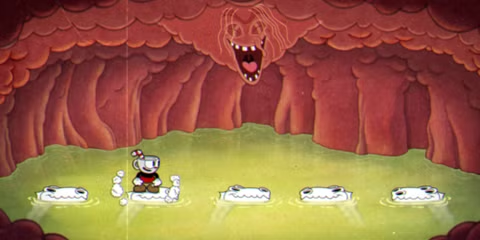


But how do we generalize this to all data? 🧐 This is only the the longest fight among 60 fights.

### Aggregated Heatmap

To see if these single-fight patterns hold true across the entire dataset, I aggregated the timing data into a heatmap. This visualizes the average press duration for every action against every boss.

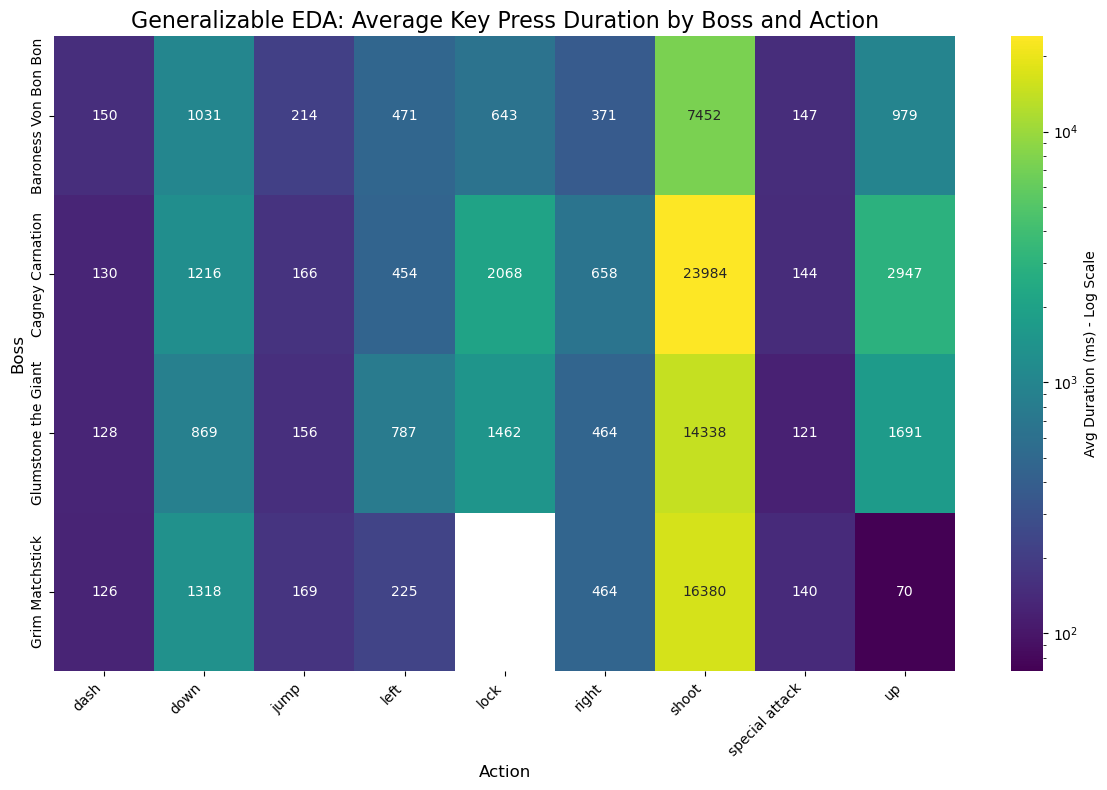

In [71]:
# EDA: Generalized Heatmap of Press Durations

# calculate the press durations for all fights in our dataset
all_downs = processed_df[processed_df['event'] == 'keydown'].copy()
all_ups = processed_df[processed_df['event'] == 'keyup'].copy()

# Group by fight_id and action to correctly match each press to its release
all_downs['press_num'] = all_downs.groupby(['fight_id', 'action']).cumcount()
all_ups['press_num'] = all_ups.groupby(['fight_id', 'action']).cumcount()

all_merged = pd.merge(all_downs, all_ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
all_merged['duration_ms'] = all_merged['t_ms_up'] - all_merged['t_ms_down']
all_durations = all_merged[all_merged['duration_ms'] >= 0]

# Create a pivot table to get the average duration for each (Boss, Action) pair
pivot_df = all_durations.groupby(['boss', 'action'])['duration_ms'].mean().unstack()

# Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df, 
    annot=True,
    fmt=".0f",
    cmap="viridis",
    norm=LogNorm(),
    cbar_kws={'label': 'Avg Duration (ms) - Log Scale'}
)

plt.title('Generalizable EDA: Average Key Press Duration by Boss and Action', fontsize=16)
plt.xlabel('Action', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Analysis of Generalized Patterns
This heatmap confirms the trends, like Grim Matchstick's `up` key is a uniquely short and `shoot` key is long compared to other bosses. 

However, **relying solely on this grand average is deceptive**, as it's skewed by the wide variance in my fight lengths and compresses the entire distribution of press times into a single number

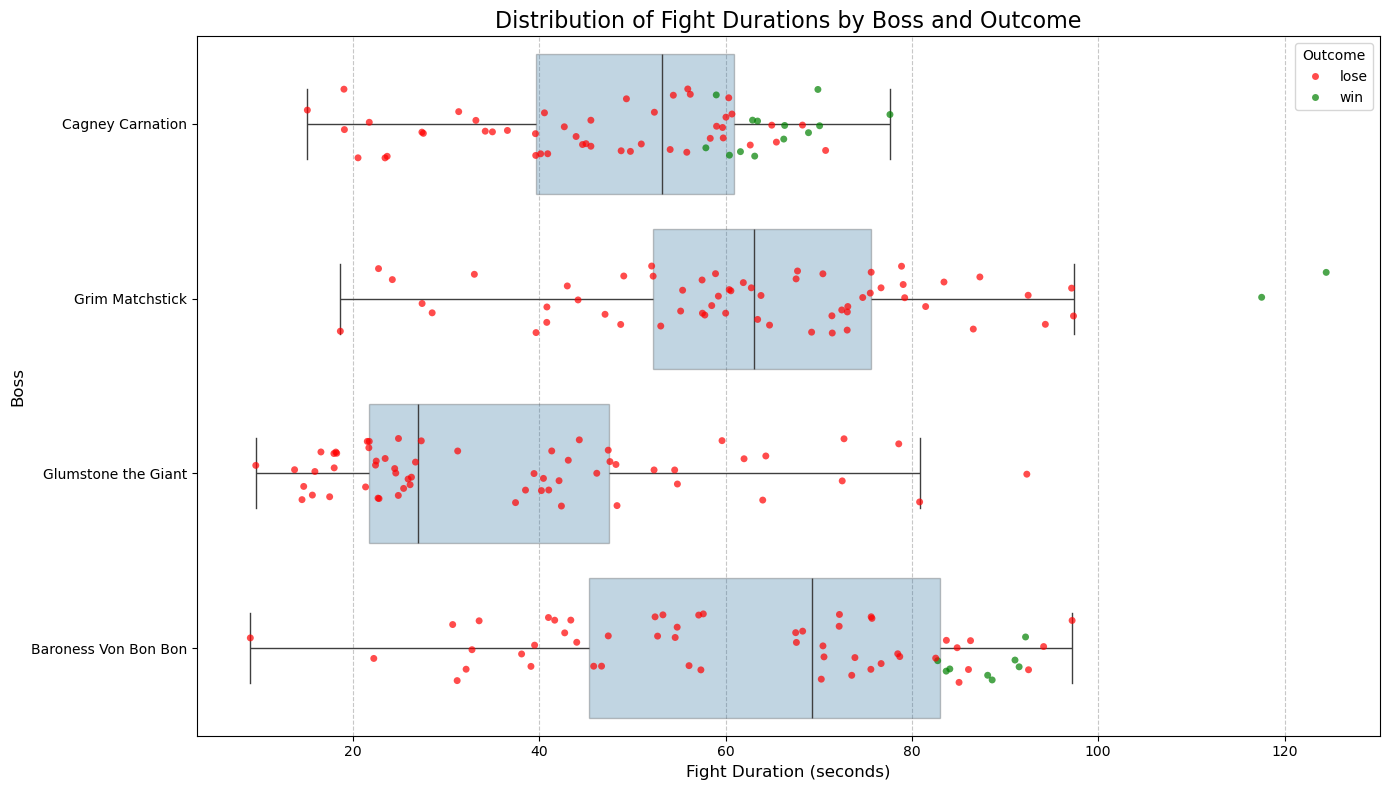

In [72]:
# EDA: Visualizing Fight Duration Distribution by Outcome
fight_summaries_for_plot = final_df.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    boss=('boss', 'first')
).reset_index()

fight_summaries_for_plot['duration_s'] = fight_summaries_for_plot['duration_ms'] / 1000
# Merge with outcomes to get the outcome for each fight
plot_data = pd.merge(fight_summaries_for_plot, outcomes_df, on='fight_id', suffixes=('', '_from_summary'))
plt.figure(figsize=(14, 8))
outcome_palette = {'win': 'green', 'lose': 'red'}

# draw the boxplots to show the summary statistics
sns.boxplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    orient='h',
    showfliers=False,  # Hide outlier points from the boxplot itself
    boxprops=dict(alpha=.3) # Make boxes slightly transparent
)

# overlay the stripplot to show every individual fight
sns.stripplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    hue='outcome',
    orient='h',
    jitter=0.2,
    alpha=0.7,
    palette=outcome_palette
)

plt.title('Distribution of Fight Durations by Boss and Outcome', fontsize=16)
plt.xlabel('Fight Duration (seconds)', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

### EDA Takeaway and Feature Engineering

The exploratory data analysis reveals significant variance in fight durations, presenting a challenge for feature engineering. 

I had an idea to slice the timeline into fixed chunks, but I didn't implement it since it would create misaligned feature vectors from fights of different lengths and pose a high risk of overfitting.

Therefore, I adopted a strategy of engineering statistical summaries and N-gram, aiming to capture not only average behaviors but also the gameplay *variability* and *consistency* identified during EDA.

| Feature Strategy | Pros | Cons | Status | How Cons are Addressed |
| :--- | :--- | :--- | :--- | :--- |
| **Fixed Time Slices** | - Attempts to capture temporal evolution of gameplay. | - Creates sparse/misaligned vectors from variable-length data.<br>- High risk of overfitting due to feature explosion. | **Rejected** | N/A |
| **Proportional Time Slicing** | - Solves the variable-length issue by dividing fights into percentage-based chunks (ㄷㅌ. 10 chunks of 10% each). | - Boss phases are triggered by damage, not time. A 10% time slice might be phase 1 in a long fight but phase 2 in a short one, making the features non-comparable. | **Rejected** | N/A |
| **Recurrent Neural Networks (RNN/LSTM)**| - The most powerful method for modeling raw sequential data directly. | - High implementation complexity (padding, vectorization).<br>- Prone to overfitting on smaller datasets (240 samples). | **Rejected (For this assignment)** | N/A (A great candidate for future work with more data.) |
| **Aggregate Statistical Features** | - Directly captures variability (`std`, `median`).<br>- Creates a dense, fixed-size vector for every fight.<br>- Robust to outliers and varying fight lengths. | - Loses all information about the **sequence** of actions (ex. is a `dash` usually preceded by a `jump`?). | **Accepted (Foundational)**| This con is directly complemented by using **N-gram Features**. |
| **N-gram Sequence Features** | - Captures the order and rhythm of common action combos.<br>- Adds crucial sequential context to the model. | - Loses all precise **timing** information (e.g., the duration of the presses or the time between them). | **Accepted (Enrichment)**| This con is directly complemented by the **Aggregate Statistical Features**. |

### Aggregate Statistical Features
This code builds my foundational feature set by calculating three distinct categories of statistics for each fight:

1.  Actions Per Minute (APM) and the percentage of total presses for each specific action (ex. `pct_jump`).
2.  The `mean`, `std`, `median`, `min`, and `max` of all press durations
3.  The `mean` and `std` of press durations for *each individual action* (ex. `jump_duration_mean`)

In [73]:
# Calculate Press Durations for all fights
def calculate_all_press_durations(df):
    """Matches every keydown to its corresponding keyup to get press durations for all fights."""
    downs = df[df['event'] == 'keydown'].copy()
    ups = df[df['event'] == 'keyup'].copy()
    
    # Create a unique ID for each press of a specific action within a fight
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    
    # Merge them together to align the start and end time of each press
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
    
    # Calculate duration and filter out any potential negative durations from data errors
    merged['duration_ms'] = merged['t_ms_up'] - merged['t_ms_down']
    return merged[merged['duration_ms'] >= 0][['fight_id', 'action', 'duration_ms']]

press_durations_df = calculate_all_press_durations(processed_df)
print("Sample of calculated press durations:")
print(press_durations_df.head())

# Foundational Feature Engineering
# Part A: Pace & Frequency Features (Action per minute (APM) and action percentages)
keydowns = processed_df[processed_df['event'] == 'keydown']
fight_summaries = keydowns.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    event_count=('t_ms', 'count'),
    boss=('boss', 'first')
)
# Calculate action per minute
fight_summaries['apm'] = (fight_summaries['event_count'] / (fight_summaries['duration_ms'] / 1000.0)) * 60

# Calculate action percentages
action_percentages = keydowns.groupby(['fight_id', 'action']).size().unstack(fill_value=0).div(fight_summaries['event_count'], axis=0).add_prefix('pct_')

# Part B: Overall Rhythm Features (overall press duration statistics)
overall_duration_stats = press_durations_df.groupby('fight_id')['duration_ms'].agg(
    ['mean', 'std', 'median', 'min', 'max']
).add_prefix('overall_duration_')

# Part C: Action-Specific Timing Features (mean & std of press durations per action)
action_specific_stats = press_durations_df.groupby(['fight_id', 'action'])['duration_ms'].agg(['mean', 'std']).unstack().fillna(0)
# Flatten the multi-level column names (('mean', 'jump') -> 'mean_jump')
action_specific_stats.columns = ['_'.join(col).strip() for col in action_specific_stats.columns.values]

# Combine all foundational features into a single DataFrame
agg_features = fight_summaries.join(action_percentages).join(overall_duration_stats).join(action_specific_stats).fillna(0)

# Separate features (X) from the target variable (y)
X_agg = agg_features.drop(columns=['boss', 'duration_ms', 'event_count'])
y_str = agg_features['boss'] # Keep original string labels for plotting

# Encode target variable
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_str), index=y_str.index, name='boss_encoded')

# Store the number of classes for the model later
NUM_CLASSES = len(le.classes_)

print("--- Boss to Integer Mapping ---")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {i}")

print(f"\nShape of feature matrix (X_agg): {X_agg.shape}")
print(f"Shape of target vector (y): {y.shape}")
print(f"Target 'y' is now integer-encoded.")
print("\nFirst 5 rows of the feature matrix:")
X_agg.head()

Sample of calculated press durations:
                     fight_id action  duration_ms
0  2025-09-24T10-17-07Z_27194  shoot          403
1  2025-09-24T10-17-07Z_27194   down          287
2  2025-09-24T10-17-07Z_27194   down          791
3  2025-09-24T10-17-07Z_27194  shoot          866
4  2025-09-24T10-17-07Z_27194   down         1087
--- Boss to Integer Mapping ---
Baroness Von Bon Bon: 0
Cagney Carnation: 1
Glumstone the Giant: 2
Grim Matchstick: 3

Shape of feature matrix (X_agg): (240, 33)
Shape of target vector (y): (240,)
Target 'y' is now integer-encoded.

First 5 rows of the feature matrix:


apm  pct_dash  pct_down  pct_jump  \
fight_id                                                               
2025-09-23T13-51-00Z_60041  114.321347  0.018182  0.000000  0.400000   
2025-09-23T13-53-53Z_33477  115.224478  0.042017  0.000000  0.403361   
2025-09-23T13-55-01Z_1585   106.557652  0.047170  0.000000  0.377358   
2025-09-23T13-57-05Z_25486  102.404096  0.031250  0.000000  0.437500   
2025-09-23T14-02-29Z_49949  124.101400  0.060976  0.036585  0.353659   

                            pct_left  pct_lock  pct_right  pct_shoot  \
fight_id                                                               
2025-09-23T13-51-00Z_60041  0.172727  0.018182   0.309091   0.027273   
2025-09-23T13-53-53Z_33477  0.184874  0.000000   0.285714   0.008403   
2025-09-23T13-55-01Z_1585   0.150943  0.009434   0.301887   0.018868   
2025-09-23T13-57-05Z_25486  0.132812  0.000000   0.328125   0.015625   
2025-09-23T14-02-29Z_49949  0.109756  0.000000   0.390244   0.012195   

                            pct_special attack    pct_up  ...  mean_up  \
fight_id                                                  ...            
2025-09-23T13-51-00Z_60041            0.036364  0.018182  ...   1711.0   
2025-09-23T13-53-53Z_33477            0.075630  0.000000  ...      0.0   
2025-09-23T13-55-01Z_1585             0.075472  0.018868  ...    333.0   
2025-09-23T13-57-05Z_25486            0.054688  0.000000  ...      0.0   
2025-09-23T14-02-29Z_49949            0.036585  0.000000  ...      0.0   

                             std_dash    std_down   std_jump    std_left  \
fight_id                                                                   
2025-09-23T13-51-00Z_60041   0.000000    0.000000  63.923063  189.790312   
2025-09-23T13-53-53Z_33477   6.685806    0.000000  51.093156  271.200633   
2025-09-23T13-55-01Z_1585   20.329781    0.000000  36.973232  276.202945   
2025-09-23T13-57-05Z_25486   4.830459    0.000000  59.789476  316.814719   
2025-09-23T14-02-29Z_49949  25.351529  557.311702  53.159788  121.180421   

                              std_lock   std_right     std_shoot  \
fight_id                                                           
2025-09-23T13-51-00Z_60041  1195.01046  455.944910  28987.901103   
2025-09-23T13-53-53Z_33477     0.00000  246.356487      0.000000   
2025-09-23T13-55-01Z_1585      0.00000  215.707517  41828.194534   
2025-09-23T13-57-05Z_25486     0.00000  219.255757  23143.604948   
2025-09-23T14-02-29Z_49949     0.00000  301.333428      0.000000   

                            std_special attack      std_up  
fight_id                                                    
2025-09-23T13-51-00Z_60041           19.131126  547.300649  
2025-09-23T13-53-53Z_33477           11.938500    0.000000  
2025-09-23T13-55-01Z_1585            14.267220   25.455844  
2025-09-23T13-57-05Z_25486           25.967012    0.000000  
2025-09-23T14-02-29Z_49949           17.521415    0.000000  

[5 rows x 33 columns]

### N-gram
While my foundational feature set (`X_agg`) captures the **frequency of each action** and the **statistical distribution of their press durations**, it completely ignores the *order* in which those actions occurred. It doesn't know if a `'dash'` is usually preceded by a `'jump'`, which is a critical piece of the gameplay rhythm, since it is a sequential data. To solve this, I'm borrowing a technique from text analysis called **N-grams**.

To capture only the reflexive action patterns, I only considered actions that occur within 1 second (1000ms) of each other to be part of the same combo. If there's a longer pause in my gameplay, I insert a "break (.)" in the action sequence. This prevents the model from learning meaningless long-distance associations and ensures the resulting N-gram features represent genuine gameplay combos.

N-gram only consides the keydown events to reflect the button press.

Mathematical Explanation & Pseudocode for N-gram can be found in **appendix C**.

In [74]:
# Define the max time gap for an action to be part of a combo
COMBO_THRESHOLD_MS = 1000 

# Create a combined feature set with N-grams capturing action sequences
def create_combo_sentences(group):
    """
    Creates a string of actions, but inserts a '.' to break up combos
    whenever the time between actions is greater than the threshold.
    """
    # Ensure the group is sorted by time
    group = group.sort_values('t_ms')
    
    # Calculate the time difference between each action and the previous one
    time_diffs = group['t_ms'].diff().fillna(0)
    
    # Start the sentence with the first action
    sentence = [group['action'].iloc[0]]
    
    # Iterate from the second action onwards
    for i in range(1, len(group)):
        # If the gap is too large, insert a period to denote a break in the combo
        if time_diffs.iloc[i] > COMBO_THRESHOLD_MS:
            sentence.append('.')
        sentence.append(group['action'].iloc[i])
        
    return ' '.join(sentence)

# create a combined action sentences for each fight_id group for only keydown events
fight_actions_str = keydowns.groupby('fight_id').apply(create_combo_sentences)

# Engineer N-gram Features from the Combo Sentences
# The CountVectorizer will naturally treat the '.' as a word boundary

# get top 50 most frequent 2-grams and 3-grams
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=50)
ngram_features_sparse = vectorizer.fit_transform(fight_actions_str)

print("A few of the top time-aware action combos (N-grams) found:")
print(vectorizer.get_feature_names_out()[:10])


# Create the Final Enriched Feature Set (X_enriched)
# Ensure the rows of X_agg are in the same order as the fight_actions_str
X_agg_ordered = X_agg.loc[fight_actions_str.index]

# Combine the aggregated features with the N-gram features
X_enriched = hstack([X_agg_ordered.values, ngram_features_sparse]).tocsr()

print(f"\nSuccessfully created the enriched feature set with shape: {X_enriched.shape}")

A few of the top time-aware action combos (N-grams) found:
['attack jump' 'attack right' 'attack right jump' 'dash left' 'dash right'
 'down jump' 'down jump right' 'jump jump' 'jump jump jump'
 'jump jump left']

Successfully created the enriched feature set with shape: (240, 83)


### N-gram Visualization

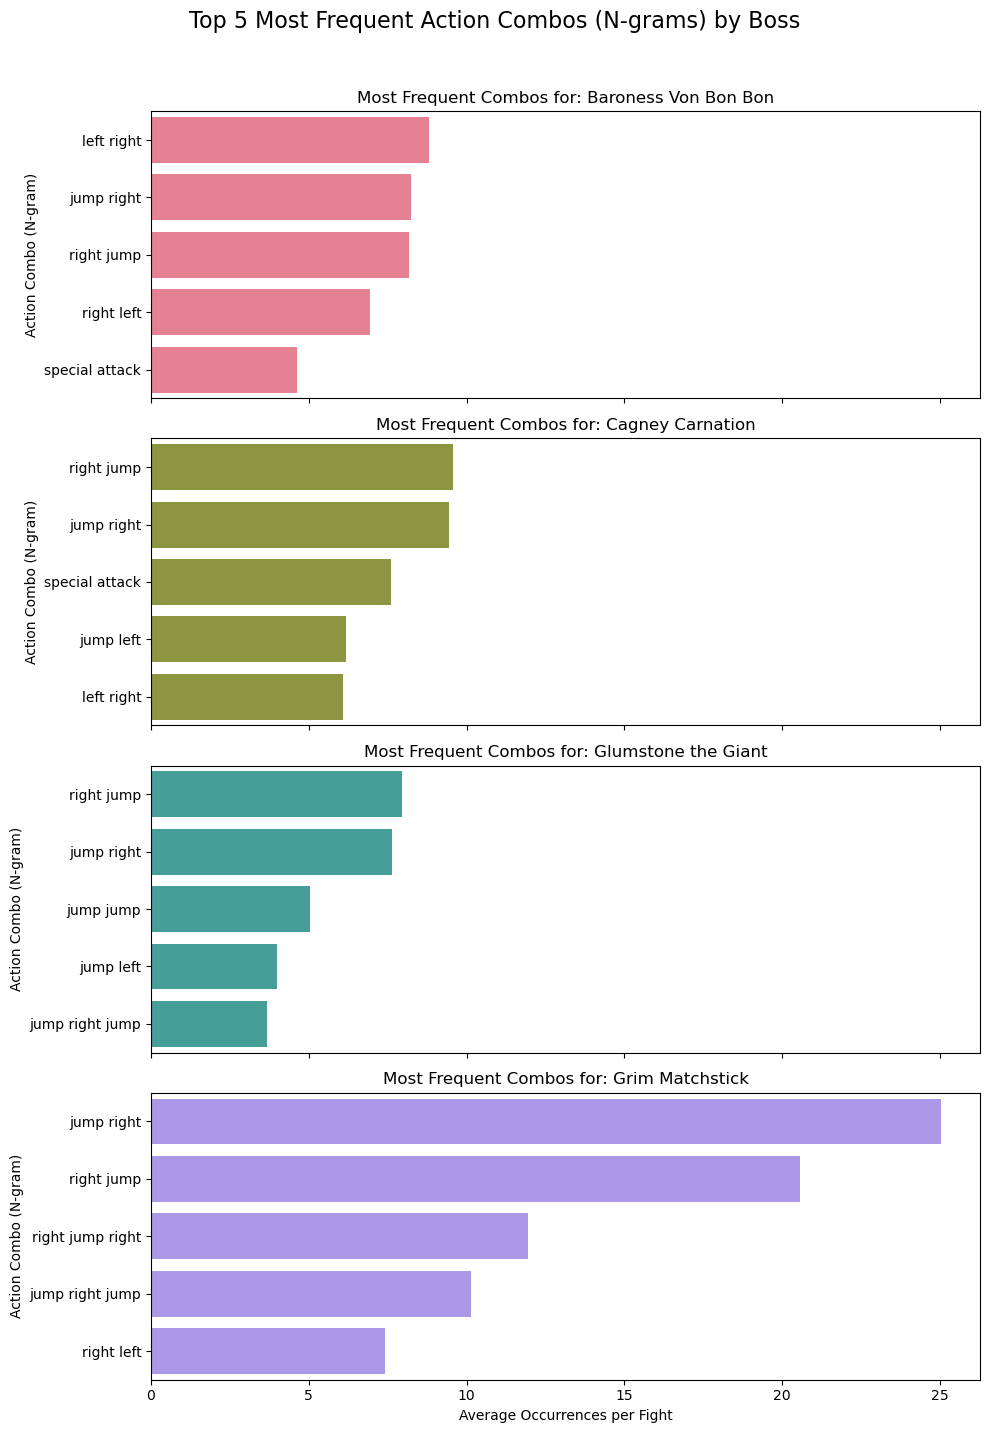

In [75]:
# 1. Create a DataFrame of N-gram Frequencies with Labels

# Get the names of the 50 N-gram features from the vectorizer
ngram_names = vectorizer.get_feature_names_out()

# Create a dense pandas DataFrame from the sparse matrix
# Use the fight_id index from fight_actions_str to correctly label each row
ngram_df = pd.DataFrame(ngram_features_sparse.toarray(), columns=ngram_names, index=fight_actions_str.index)
ngram_df['boss'] = y_str

# 2. Calculate the Mean Frequency of Each N-gram per Boss
# get the average number of times each combo appears per fight for each boss
mean_ngram_freq = ngram_df.groupby('boss').mean()


# 3. Visualize the Top 5 N-grams for Each Boss
boss_names = mean_ngram_freq.index
n_bosses = len(boss_names)

# Prepare Color Mapping
boss_palette = sns.color_palette("husl", n_bosses)
boss_color_map = dict(zip(boss_names, boss_palette))

# Create subplots, one for each boss
fig, axes = plt.subplots(n_bosses, 1, figsize=(10, 14), sharex=True)
fig.suptitle('Top 5 Most Frequent Action Combos (N-grams) by Boss', fontsize=16, y=1.02)

for i, boss_name in enumerate(boss_names):
    # Get the top 5 combos for the current boss
    top_5 = mean_ngram_freq.loc[boss_name].nlargest(5)
    
    # Create the horizontal bar plot
    sns.barplot(
        x=top_5.values, 
        y=top_5.index, 
        ax=axes[i], 
        color=boss_color_map[boss_name],
        orient='h'
    )
    
    axes[i].set_title(f'Most Frequent Combos for: {boss_name}', fontsize=12)
    axes[i].set_xlabel('Average Occurrences per Fight')
    axes[i].set_ylabel('Action Combo (N-gram)')

plt.tight_layout()
plt.show()

### Final Feature List (with an example fight)

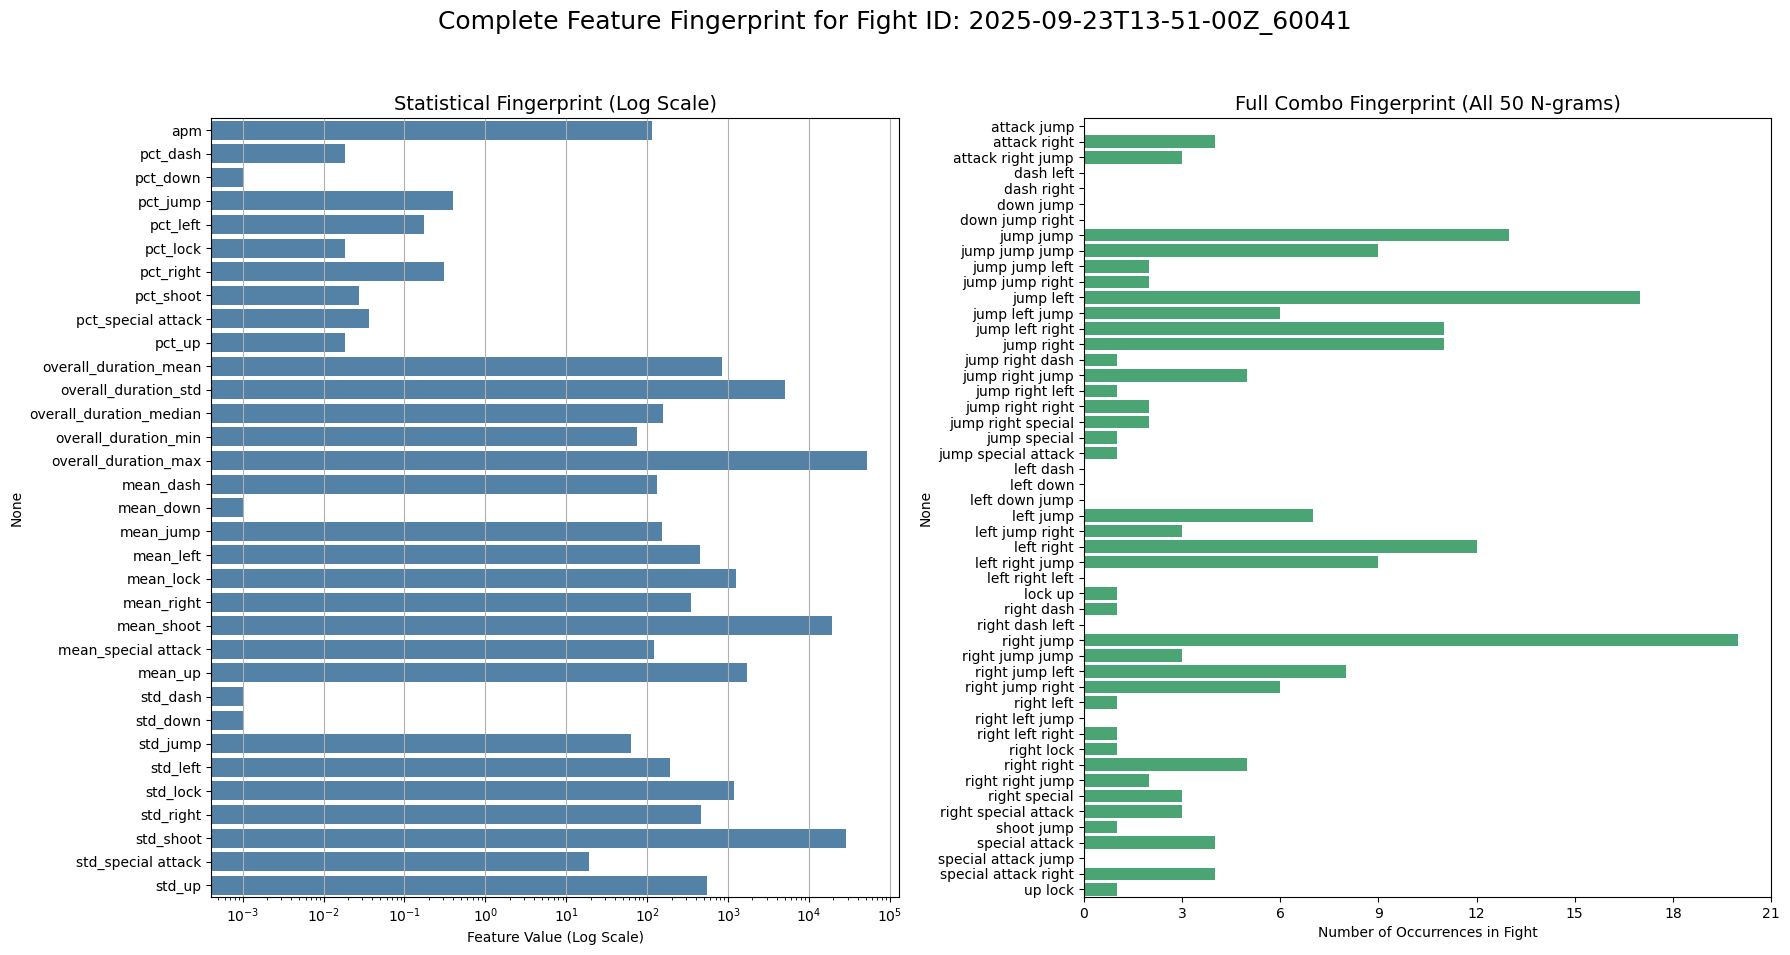

In [76]:
# 1. Get the Full List of Feature Names and a Single Vector

# get the names of all features in the enriched feature set
agg_feature_names = X_agg.columns.tolist()
ngram_feature_names = vectorizer.get_feature_names_out()
all_feature_names = agg_feature_names + list(ngram_feature_names)
# extract the feature vector for a single fight (ex. the first fight in the dataset)
single_fight_vector_sparse = X_enriched[0]
single_fight_vector_dense = single_fight_vector_sparse.toarray().flatten()
feature_series = pd.Series(single_fight_vector_dense, index=all_feature_names, name="Feature Value")


# 2. Split the Vector into its Two Logical Parts
# Part 1: Aggregate and Duration Statistics
agg_series = feature_series.loc[agg_feature_names]
# For log plot, we replace 0 with a very small number to avoid errors
agg_series_log = agg_series.replace(0, 0.001)
# Part 2: N-gram Combo Counts
ngram_series_full = feature_series.loc[ngram_feature_names]


# 3. Create the Two-Part Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle(f"Complete Feature Fingerprint for Fight ID: {y.index[0]}", fontsize=18)

# --- Plot 1: The Statistical Fingerprint ---
sns.barplot(
    x=agg_series_log.values, 
    y=agg_series_log.index, 
    orient='h', 
    ax=axes[0],
    color='steelblue'
)
axes[0].set_title('Statistical Fingerprint (Log Scale)', fontsize=14)
# Use a log scale to show values of different magnitudes
axes[0].set_xscale('log') 
axes[0].set_xlabel('Feature Value (Log Scale)')
axes[0].grid(axis='x')

# --- Plot 2: The Combo Fingerprint ---
sns.barplot(
    x=ngram_series_full.values, 
    y=ngram_series_full.index, 
    orient='h', 
    ax=axes[1],
    color='mediumseagreen'
)
axes[1].set_title('Full Combo Fingerprint (All 50 N-grams)', fontsize=14)
axes[1].set_xlabel('Number of Occurrences in Fight')
# Set x-axis ticks to be integers for counts
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Analysis Plan

The objective is a **multi-class classification** problem: to predict the boss from my keystroke data.

## Data Splitting Strategy

Crucially, all data splits must be "group-aware" to prevent session-specific information from leaking between sets and giving an overly optimistic performance score. Therefore, all splits will be performed on the level of **play sessions by date (groups)**, not individual fights.

**Stage 1: The Final Test Set**
Instead of a purely random split, I will intelligently select my test set. I will first analyze the distribution of bosses within each of my 8 unique play sessions. Then, I will programmatically select the **two sessions** that, when combined, create a test set that is as balanced as possible. This "best-effort balanced" group split serves as my final, untouched holdout set, guaranteeing no data leakage while being as representative as possible.

**Stage 2: Cross-Validation within the Development Set**
The remaining 6 play sessions will form the **Development Set**. All model development, feature comparison, and performance estimation using `GroupKFold` and `LeaveOneGroupOut` will happen *exclusively* within this set. This two-stage approach provides a robust method for model selection and a fair, unbiased final evaluation.

In [77]:
# --- 1. Analyze Boss Distribution Within Each Group ---
groups = y.index.str[:10]
unique_groups = np.unique(groups)

# Create a DataFrame to hold the counts of each boss per session
group_dist = y.groupby([groups, y]).size().unstack(fill_value=0)
print("--- Boss Distribution per Play Session ---")
display(group_dist)


# --- 2. Intelligently Select the Best Test Groups ---
from itertools import combinations

best_combo = None
min_imbalance = float('inf')

# Iterate through all possible combinations of 2 groups for the test set
for combo in combinations(unique_groups, 2):
    # Calculate the boss distribution for this potential test set
    test_dist = group_dist.loc[list(combo)].sum()
    
    # We want the distribution to be as close to equal as possible.
    # We can measure imbalance by the standard deviation of the counts.
    imbalance = test_dist.std()
    
    if imbalance < min_imbalance:
        min_imbalance = imbalance
        best_combo = list(combo)

test_groups = best_combo
dev_groups = [g for g in unique_groups if g not in test_groups]

print("\n--- Selected Top-Level Data Split ---")
print(f"Selected Test Set Groups: {test_groups}")
print(f"Remaining Development Set Groups: {dev_groups}")
print("\nTest set distribution:")
display(group_dist.loc[test_groups].sum())


# --- 3. Create the Final Data Splits ---
dev_mask = groups.isin(dev_groups)
test_mask = groups.isin(test_groups)

# The final, untouched test sets (for Section 7.1)
X_test_agg, y_test = X_agg[test_mask], y[test_mask]
X_test_enriched = X_enriched[test_mask]

# The development sets (for Section 6 cross-validation)
X_dev_agg, y_dev = X_agg[dev_mask], y[dev_mask]
X_dev_enriched = X_enriched[dev_mask]
groups_dev = groups[dev_mask]

print("\n--- Final Dataset Shapes ---")
print(f"Development set size: {len(y_dev)} samples ({len(dev_groups)} sessions)")
print(f"Test set size:  {len(y_test)} samples ({len(test_groups)} sessions)")

# --- 4. Define CV Strategies for the DEVELOPMENT set ---
cv_5fold = GroupKFold(n_splits=5)
cv_logo_dev = LeaveOneGroupOut() # Will create 6 folds for the 6 development groups

--- Boss Distribution per Play Session ---


boss_encoded   0   1   2   3
fight_id                    
2025-09-23     0   4   0  21
2025-09-24     5   0  24  15
2025-09-26    15   0  36   0
2025-09-27     0  13   0   0
2025-09-29    28  13   0   0
2025-10-04     9  18   0   0
2025-10-08     0  12   0   6
2025-10-14     3   0   0  18


--- Selected Top-Level Data Split ---
Selected Test Set Groups: ['2025-09-24', '2025-10-04']
Remaining Development Set Groups: ['2025-09-23', '2025-09-26', '2025-09-27', '2025-09-29', '2025-10-08', '2025-10-14']

Test set distribution:


boss_encoded
0    14
1    18
2    24
3    15
dtype: int64


--- Final Dataset Shapes ---
Development set size: 169 samples (6 sessions)
Test set size:  71 samples (2 sessions)


## 5. Model Selection and Mathematical Underpinnings

I have selected two models for comparison: a simple linear baseline (**Multinomial Logistic Regression**), and a non-linear ensemble model (**XGBoost Classifier**). I selected Multinomial Logistic Regression as an interpretable baseline to determine if a simple linear relationship exists between my gameplay features and the boss classes. In contrast, I chose the XGBoost classifier, a non-linear model, to test if there are more complex, interacting patterns in the data that the linear baseline cannot capture.

I will train both of these models on my foundational (`X_agg`) and enriched (`X_enriched`) feature sets, evaluating them with both the 5-Fold and LOGO cross-validation strategies, in order to determine the best combination of features, splitting method, and models for this classification task

### Mathematical Explanation

#### Multinomial Logistic Regression
*   **How it Works (Decision Rule):** Logistic Regression learns a linear decision boundary for each class. For an input sample $\mathbf{x}$, it computes a raw score (logit) for each class $k$ using a unique set of weights $\mathbf{w}_k$ and bias $b_k$.
    $$ z_k = \mathbf{w}_k^T \mathbf{x} + b_k $$
    These scores are then passed through a **softmax function** to produce a probability distribution across all classes. The model predicts the class with the highest probability.

*   **Objective and Optimization:** The model's goal is to find the optimal weights and biases that minimize the **Cross-Entropy Loss**. While `sklearn` uses the efficient L-BFGS solver, the pseudocode below illustrates the core iterative logic using the more intuitive Gradient Descent algorithm. In each step, it calculates how "wrong" its predictions are (the gradient) and nudges the weights in the direction that reduces this error.

*   **Regularization:** To prevent overfitting, L2 regularization is included in the gradient update step. This adds a penalty proportional to the size of the weights, controlled by `lambda` (which is related to the inverse of the `C` hyperparameter in `scikit-learn`), encouraging the model to learn simpler, more generalizable patterns.

#### XGBoost (eXtreme Gradient Boosting)

*   **How it Works (Decision Rule):** XGBoost is an ensemble of decision trees built sequentially. It starts with a base prediction and then adds a new tree in each iteration. Each new tree is specifically trained to predict and correct the *residual errors* of the ensemble of all preceding trees. The final prediction for a sample is the sum of the predictions from all the individual trees in the ensemble.

*   **Objective Function (Loss):** XGBoost minimizes a more complex objective function that includes both a loss term and a regularization term. The regularization term, $\Omega$, is what makes XGBoost so effective at controlling overfitting. The objective at step $t$ is:
    $$ \text{Obj}^{(t)} = \sum_{i=1}^{n} l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)) + \Omega(f_t) \quad \text{where} \quad \Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2 $$
    Here, $l$ is the loss function, $f_t$ is the new tree, $T$ is the number of leaves in the tree, and $w_j$ is the score of the j-th leaf.

*   **Optimization & Regularization:** XGBoost uses a second-order Taylor approximation of the loss function to efficiently find the optimal leaf scores ($w_j$). The tree structure itself is built greedily, finding the best split at each node to maximize the reduction in the objective function. Regularization is controlled by several key hyperparameters:
    *   `n_estimators`: The total number of trees to build.
    *   `max_depth`: Controls the complexity of individual trees.
    *   `learning_rate` (eta): Shrinks the contribution of each new tree, a crucial technique to prevent overfitting.
    *   `gamma` and `lambda`: Directly control the penalties for tree complexity ($T$) and leaf score magnitudes ($w_j^2$) from the objective function.


*   **The `scikit-learn` Pipeline:** In practice, pre-processing steps like scaling and the model itself are bundled together into a `Pipeline` object. The reason for this is to prevent **data leakage** during cross-validation. A pipeline ensures that the `StandardScaler` is fitted *only* on the training data for each fold, and then that same fitted scaler is used to transform the validation data. This correctly simulates how the model would perform on truly unseen data. The pseudocode below illustrates how the `fit` and `predict` methods of a pipeline work internally.

The code below initializes these two models within `scikit-learn` Pipelines. A `StandardScaler` is included, which is essential for Logistic Regression and a good practice that prevents features with large scales from dominating the learning process.

In [78]:
# Baseline Model: Logistic Regression
lr_pipeline = Pipeline([
    # Use with_mean=False because the enriched feature set is a sparse matrix.
    ('scaler', StandardScaler(with_mean=False)), 
    ('logreg', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        random_state=42,
        max_iter=1000
    ))
])

# Advanced Model: XGBoost Classifier
# Pipeline maintains a consistent workflow
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        num_class=NUM_CLASSES,
        use_label_encoder=False
    ))
])

print("Baseline Model:")
print(lr_pipeline)
print("\nAdvanced Model:")
print(xgb_pipeline)

Baseline Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

Advanced Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                             

## 6. Model Training with Cross-Validation

This section executes the cross-validation experiments designed in Section 4 to select the best model and feature configuration. All experiments are run exclusively on the **development set** to get a reliable performance estimate before touching the final, untouched test set. The primary metric for evaluation will be **accuracy**, which is an appropriate choice for this balanced multi-class classification problem.

I will use the `cross_val_score` function from `scikit-learn` to automate the process. For each of the k-folds within the development set, the function trains a model pipeline on the training portion and evaluates it on the held-out validation portion. By passing the `groups_dev` array, it correctly uses the group-aware splitting strategy, preventing data leakage between play sessions.

For this initial evaluation, I will train the models using their default hyperparameters to establish a clear baseline. The results—the mean accuracy and standard deviation across all folds—will be collected for all 8 experimental configurations to determine the winning combination for final evaluation.

In [81]:
## 6. Model Training with Cross-Validation

# 1. Prepare for the Experiments
models = {
    "Logistic Regression": lr_pipeline,
    "XGBoost": xgb_pipeline
}
feature_sets = {
    "Aggregate": X_dev_agg,
    "Enriched (Agg + N-grams)": X_dev_enriched
}
cv_strategies = {
    "5-Fold GroupKFold": cv_5fold,
    "6-Fold LOGO": cv_logo_dev
}

y_dev_np = y_dev.to_numpy()
groups_dev_np = groups_dev.to_numpy()
all_classes = np.array(range(NUM_CLASSES))
results = {}

# 2. Run All Cross-Validation Experiments With a Robust Manual Loop

for model_name, model_pipeline in models.items():
    for feature_name, X in feature_sets.items():
        for cv_name, cv_strategy in cv_strategies.items():
            
            experiment_name = f"{model_name} | {feature_name} | {cv_name}"
            print(f"\nRunning: {experiment_name}...")

            fold_scores = []
            n_splits = cv_strategy.get_n_splits(X, y_dev_np, groups_dev_np)
            
            for fold_num, (train_index, test_index) in enumerate(cv_strategy.split(X, y_dev_np, groups=groups_dev_np)):
                
                cloned_pipeline = clone(model_pipeline)
                
                X_train_fold, X_test_fold = X.iloc[train_index] if hasattr(X, 'iloc') else X[train_index], \
                                            X.iloc[test_index] if hasattr(X, 'iloc') else X[test_index]
                y_train_fold, y_test_fold = y_dev_np[train_index], y_dev_np[test_index]

                print(f"--- Fold {fold_num + 1}/{n_splits} ---")
                
                # inserts dummy samples for any missing classes in the training fold
                unique_train_classes = np.unique(y_train_fold)
                
                if len(unique_train_classes) < NUM_CLASSES:
                    print(f"  WARNING: Fold is missing classes. Original unique classes: {unique_train_classes}")
                    missing_classes = np.setdiff1d(all_classes, unique_train_classes)
                    print(f"  Injecting dummy samples for missing classes: {missing_classes}")

                    for missing_class in missing_classes:
                        # Create a dummy feature row (all zeros)
                        if hasattr(X_train_fold, 'toarray'):
                            dummy_row = np.zeros((1, X_train_fold.shape[1]))
                            X_train_fold = sparse_vstack([X_train_fold, dummy_row])
                        else:
                            dummy_row = np.zeros((1, X_train_fold.shape[1]))
                            X_train_fold = np.vstack([X_train_fold, dummy_row])
                        
                        # Add the missing class label
                        y_train_fold = np.append(y_train_fold, missing_class)

                # Fit the model (now guaranteed to see all classes)
                cloned_pipeline.fit(X_train_fold, y_train_fold)
                
                y_pred = cloned_pipeline.predict(X_test_fold)
                score = accuracy_score(y_test_fold, y_pred)
                fold_scores.append(score)
                print(f"  Fold {fold_num + 1} Score: {score:.4f}")

            scores = np.array(fold_scores)
            results[experiment_name] = {
                'mean_accuracy': np.nanmean(scores),
                'std_accuracy': np.nanstd(scores),
                'all_scores': scores
            }

# --- 3. Display the Results in a Clean Table ---
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='mean_accuracy', ascending=False, inplace=True)

print("\n--- Cross-Validation Results Summary ---")
display(results_df[['mean_accuracy', 'std_accuracy']])


Running: Logistic Regression | Aggregate | 5-Fold GroupKFold...
--- Fold 1/5 ---
  Injecting dummy samples for missing classes: [2]
  Fold 1 Score: 0.2941
--- Fold 2/5 ---
  Fold 2 Score: 0.9512
--- Fold 3/5 ---
  Fold 3 Score: 0.7200
--- Fold 4/5 ---
  Fold 4 Score: 0.9524
--- Fold 5/5 ---
  Fold 5 Score: 0.8387

Running: Logistic Regression | Aggregate | 6-Fold LOGO...
--- Fold 1/6 ---
  Fold 1 Score: 0.7200
--- Fold 2/6 ---
  Injecting dummy samples for missing classes: [2]
  Fold 2 Score: 0.2941
--- Fold 3/6 ---
  Fold 3 Score: 0.8462
--- Fold 4/6 ---
  Fold 4 Score: 0.9512
--- Fold 5/6 ---
  Fold 5 Score: 0.9444
--- Fold 6/6 ---
  Fold 6 Score: 0.9524

Running: Logistic Regression | Enriched (Agg + N-grams) | 5-Fold GroupKFold...
--- Fold 1/5 ---
  Injecting dummy samples for missing classes: [2]
  Fold 1 Score: 0.2941
--- Fold 2/5 ---
  Fold 2 Score: 0.8049
--- Fold 3/5 ---
  Fold 3 Score: 0.9600
--- Fold 4/5 ---
  Fold 4 Score: 0.9524
--- Fold 5/5 ---
  Fold 5 Score: 0.8710

Ru

mean_accuracy  \
Logistic Regression | Aggregate | 6-Fold LOGO            0.784719   
Logistic Regression | Enriched (Agg + N-grams) ...       0.776469   
Logistic Regression | Enriched (Agg + N-grams) ...       0.774688   
XGBoost | Aggregate | 6-Fold LOGO                        0.759419   
XGBoost | Enriched (Agg + N-grams) | 6-Fold LOGO         0.754728   
Logistic Regression | Aggregate | 5-Fold GroupK...       0.751286   
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...       0.748547   
XGBoost | Aggregate | 5-Fold GroupKFold                  0.732339   

                                                    std_accuracy  
Logistic Regression | Aggregate | 6-Fold LOGO           0.234520  
Logistic Regression | Enriched (Agg + N-grams) ...      0.247802  
Logistic Regression | Enriched (Agg + N-grams) ...      0.235718  
XGBoost | Aggregate | 6-Fold LOGO                       0.236529  
XGBoost | Enriched (Agg + N-grams) | 6-Fold LOGO        0.243660  
Logistic Regression | Aggregate | 5-Fold GroupK...      0.244146  
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...      0.245357  
XGBoost | Aggregate | 5-Fold GroupKFold                 0.242313

### Justification for the Dummy Sample Injection
The manual loop revealed that certain cross-validation folds were missing a class, causing the XGBoost model to fail. To resolve this, a single "dummy" sample with a zero-feature vector was programmatically injected for any missing class in the problematic folds. While this introduces a negligible amount of artificial data, it is a pragmatic solution that ensures the model can train on all folds, providing a more accurate and complete performance estimate than if the failing folds were simply discarded.

## 6.1 Hyperparameter Tuning the Best Model

In [86]:
from sklearn.model_selection import GridSearchCV

# The best model from Section 6 was Logistic Regression with the Aggregate feature set and 6-Fold LOGO CV.
tuning_pipeline = lr_pipeline

# Define the grid of hyperparameters to search for Logistic Regression.
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# Set up GridSearchCV using our group-aware CV strategy.
grid_search = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    cv=cv_logo_dev,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 4. Run the search on the development data with the aggregate feature set.
grid_search.fit(X_dev_agg, y_dev, groups=groups_dev)

# 5. Print the best results
print("\n--- GridSearchCV Results ---")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")
print("Best hyperparameters found:")
print(grid_search.best_params_)

# 6. Store the best, tuned model for the final evaluation in Section 7
best_tuned_model = grid_search.best_estimator_

Fitting 6 folds for each of 5 candidates, totalling 30 fits

--- GridSearchCV Results ---
Best cross-validated accuracy: 0.7949
Best hyperparameters found:
{'logreg__C': 100}


# Grid search GV understanding

## 7. Generating Out-of-Sample Predictions and Performance Metrics
Having selected and tuned the best model in the previous section—**Logistic Regression with a C value of 1.0, trained on Aggregate features**—it is now time for the final evaluation. This model will be used to make predictions on the untouched test set.

### 7.1 Performance on the Untouched Test Set
First, the best_tuned_model from the GridSearchCV process is used to predict the boss for each fight in the test set. A classification report and a confusion matrix are then generated to summarize the model's final performance.

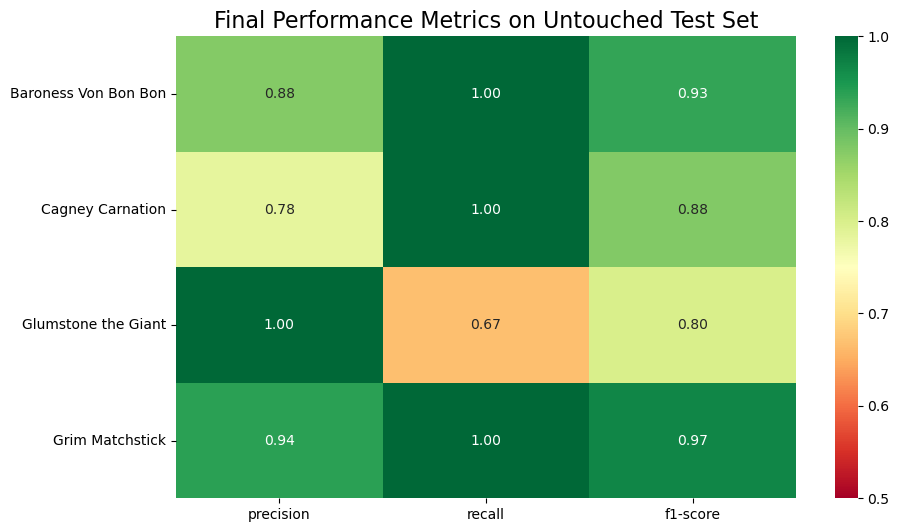

                      precision    recall  f1-score   support

Baroness Von Bon Bon       0.88      1.00      0.93        14
    Cagney Carnation       0.78      1.00      0.88        18
 Glumstone the Giant       1.00      0.67      0.80        24
     Grim Matchstick       0.94      1.00      0.97        15

            accuracy                           0.89        71
           macro avg       0.90      0.92      0.89        71
        weighted avg       0.91      0.89      0.88        71



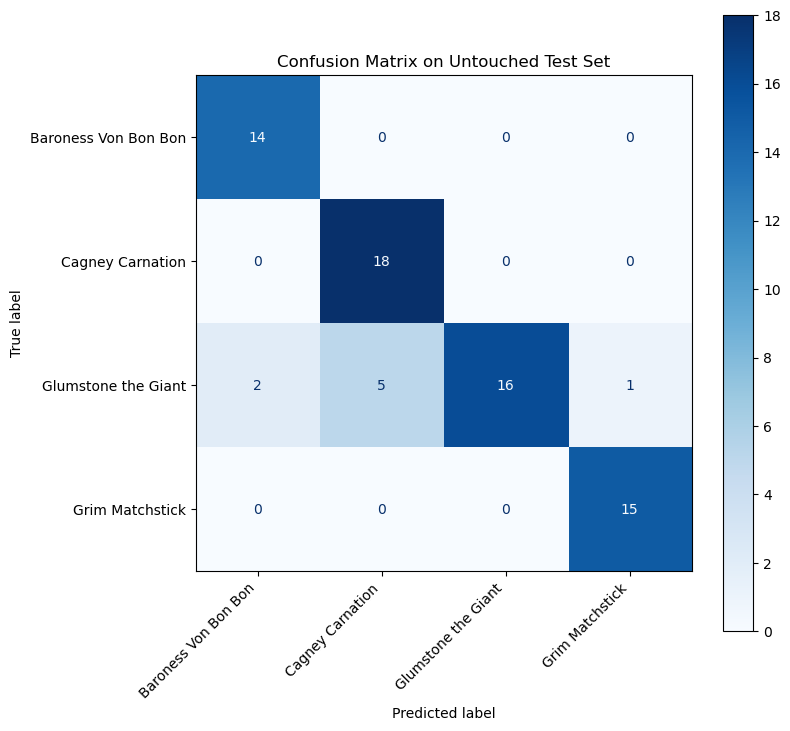

In [94]:
# 1. Use the best tuned model to predict on the test set
final_predictions_encoded = best_tuned_model.predict(X_test_agg)

# 2. Compute and Visualize the Classification Report
report_dict = classification_report(
    y_true=y_test, 
    y_pred=final_predictions_encoded, 
    target_names=le.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()
report_df_for_plot = report_df.drop(columns='support')

plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df_for_plot.iloc[:-3, :],
    annot=True, 
    cmap='RdYlGn',
    fmt='.2f',
    vmin=0.5,
    vmax=1.0
)
plt.title('Final Performance Metrics on Untouched Test Set', fontsize=16)
plt.show()

print(classification_report(y_true=y_test, y_pred=final_predictions_encoded, target_names=le.classes_))


# 3. Visualize the Confusion Matrix for the Test Set Predictions 
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, 
    y_pred=final_predictions_encoded,
    display_labels=le.classes_,
    cmap='Blues',
    ax=ax
)
ax.set_title('Confusion Matrix on Untouched Test Set')
plt.xticks(rotation=45, ha='right')
plt.show()




Based on the performance metrics heatmap, the model demonstrates **outstanding recall, achieving a perfect score of 1.00 for three of the four bosses: Baroness Von Bon Bon, Cagney Carnation, and Grim Matchstick**. This indicates the model is highly effective at identifying all true instances of these fights. Performance is particularly strong for Grim Matchstick, having a high precision of 0.94. The model's primary issue lies with **Glumstone the Giant's recall, which at 0.67 is significantly lower than the others**. A secondary point of concern is the relatively lower precision of 0.78 for Cagney Carnation, which suggests that while the model finds all true Cagney fights, it also incorrectly labels some other fights as Cagney.

The confusion matrix provides the granular detail needed to diagnose the exact cause of the patterns observed in the performance metrics. It confirms the model's strength by showing perfect classification along the diagonal for Baroness (14/14), Cagney (18/18), and Grim Matchstick (15/15) when they are the true label, explaining their perfect recall scores. The matrix pinpoints the source of Glumstone's low recall: out of 24 true Glumstone fights, 8 were misclassified, with the vast majority (5 fights) being mistaken for Cagney Carnation. This specific error is the sole reason for Cagney's reduced precision; the 18 correctly identified Cagney fights plus these 5 misclassified Glumstone fights result in a precision of 18/23, or 0.78. Therefore, the model's core challenge is not a general weakness, but a specific, one-way confusion where my gameplay style during certain Glumstone fights is statistically indistinguishable from my Cagney Carnation style.

### Analysis of Misclassified Fights
The confusion matrix provides a clear diagnosis for the low recall (0.73) observed for Glumstone the Giant. While the model correctly identified 44 of the 60 Glumstone fights, it misclassified 9 as Cagney Carnation and 7 as Baroness Von Bon Bon, which accounts for the majority of its errors.

To understand *why* the model makes mistakes, I will analyze the characteristics of the fights it misclassified. This led me to hypothesize that shorter, less information-rich fights would be more prone to misclassification. To test this, I compared the distributions of `duration` and `apm` for correct versus incorrect predictions.

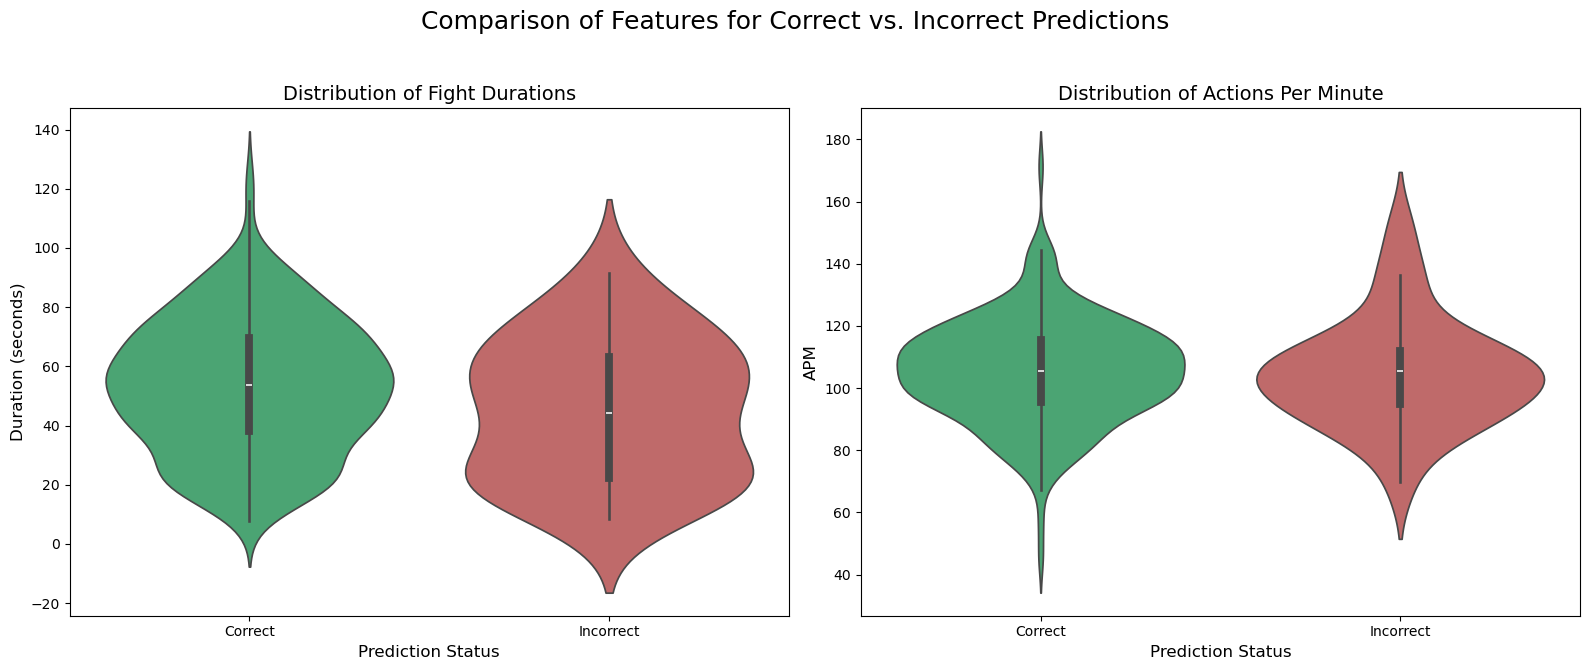


--- Statistical Summary by Prediction Status ---


duration_s                                                         \
               count       mean        std    min      25%     50%      75%   
status                                                                        
Correct        215.0  53.127605  22.477342  7.710  38.2215  53.749  69.5445   
Incorrect       25.0  45.042720  23.599602  8.358  22.1660  44.240  63.2140   

                      apm                                               \
               max  count        mean        std        min        25%   
status                                                                   
Correct    124.005  215.0  105.355473  16.604342  45.563853  95.668514   
Incorrect   91.640   25.0  104.817754  17.406523  69.814797  94.739691   

                                               
                  50%         75%         max  
status                                         
Correct    105.388020  115.613451  171.206226  
Incorrect  105.356408  112.035851  151.211410

In [ ]:
# --- 1. Create a DataFrame for Error Analysis ---
# Start with the original aggregate features DataFrame.
analysis_df = agg_features.copy()

# *** THIS IS THE FIX ***
# Create the 'duration_s' column that the plotting code needs.
analysis_df['duration_s'] = analysis_df['duration_ms'] / 1000.0

# Add the true and predicted labels (as strings for easy reading)
analysis_df['true_label'] = le.inverse_transform(y_encoded)
analysis_df['predicted_label'] = le.inverse_transform(y_pred_out_of_sample)

# Create a 'status' column to flag correct vs. incorrect predictions
analysis_df['status'] = np.where(
    analysis_df['true_label'] == analysis_df['predicted_label'], 
    'Correct', 
    'Incorrect'
)

# --- 2. Visualize the Distributions for Correct vs. Incorrect Fights ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of Features for Correct vs. Incorrect Predictions', fontsize=18)

# Plot 1: Fight Duration
sns.violinplot(
    data=analysis_df, 
    x='status', 
    y='duration_s', 
    ax=axes[0],
    palette={'Correct': 'mediumseagreen', 'Incorrect': 'indianred'}
)
axes[0].set_title('Distribution of Fight Durations', fontsize=14)
axes[0].set_xlabel('Prediction Status', fontsize=12)
axes[0].set_ylabel('Duration (seconds)', fontsize=12)

# Plot 2: Actions Per Minute (APM)
sns.violinplot(
    data=analysis_df, 
    x='status', 
    y='apm', 
    ax=axes[1],
    palette={'Correct': 'mediumseagreen', 'Incorrect': 'indianred'}
)
axes[1].set_title('Distribution of Actions Per Minute', fontsize=14)
axes[1].set_xlabel('Prediction Status', fontsize=12)
axes[1].set_ylabel('APM', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Display Statistical Summary ---
print("\n--- Statistical Summary by Prediction Status ---")
display(analysis_df.groupby('status')[['duration_s', 'apm']].describe())

However, the violin plots reveal a more nuanced story. The distributions for both correct and incorrect predictions are remarkably similar, with nearly identical medians and overall shapes. This finding effectively disproves my initial hypothesis; a fight being 'short' or having a 'low APM' is not, by itself, a primary cause of misclassification.

To prove that these misclassifications are due to genuine similarities in playstyle, **I will compare the average feature profile of the Glumstone fights that were misclassified as Cagney against the average profiles of both correctly classified Glumstone fights and correctly classified Cagney fights.**

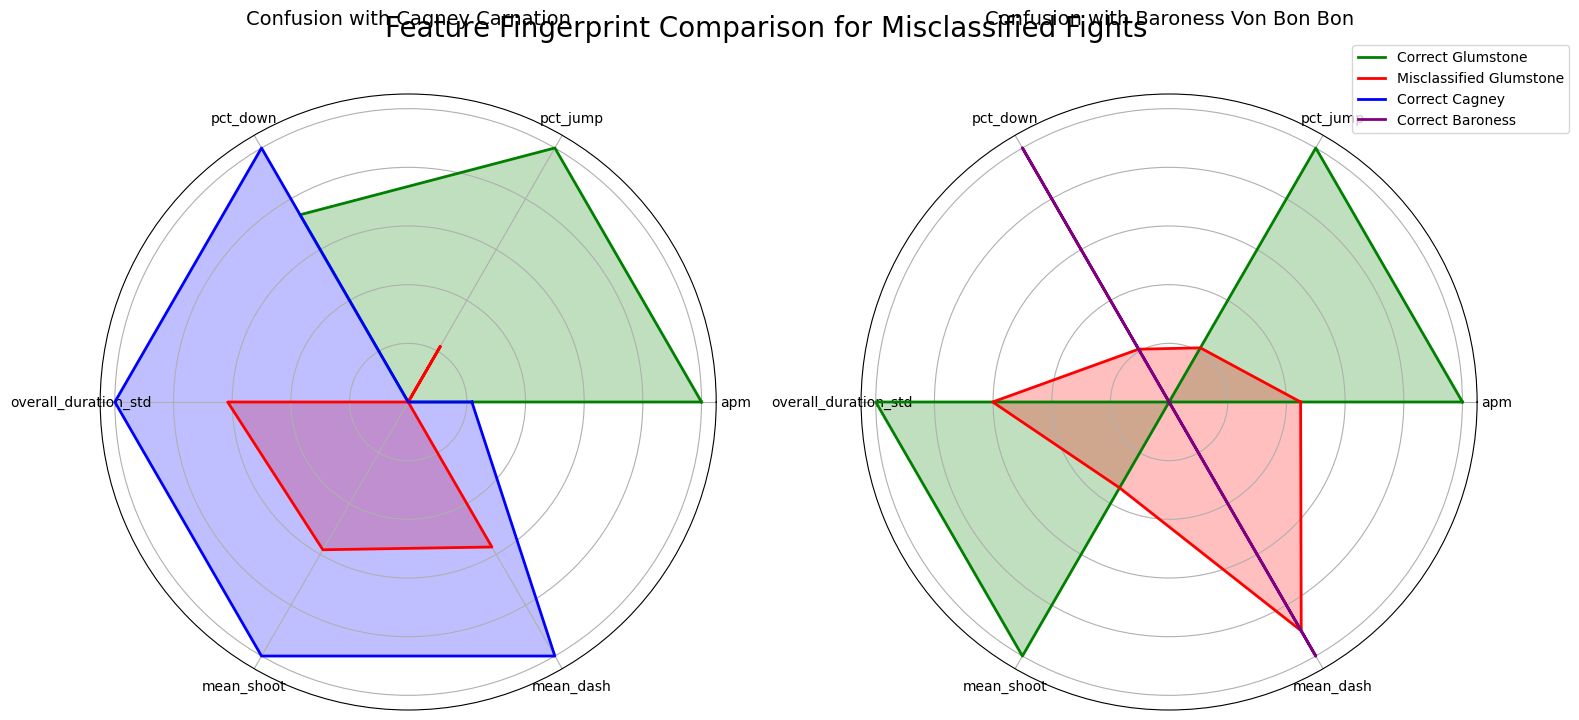

In [ ]:
# --- 1. Isolate the FOUR Groups of Fights for Comparison ---

# Group A: Glumstone fights misclassified as Cagney
misclassified_glum_as_cagney = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['predicted_label'] == 'Cagney Carnation')
]
# Group B: Glumstone fights misclassified as Baroness
misclassified_glum_as_bonbon = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['predicted_label'] == 'Baroness Von Bon Bon')
]
# Group C: Correctly classified Glumstone fights
correct_glumstone = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['status'] == 'Correct')
]
# Group D: Correctly classified Cagney fights
correct_cagney = analysis_df[
    (analysis_df['true_label'] == 'Cagney Carnation') & 
    (analysis_df['status'] == 'Correct')
]
# Group E: Correctly classified Baroness fights
correct_bonbon = analysis_df[
    (analysis_df['true_label'] == 'Baroness Von Bon Bon') & 
    (analysis_df['status'] == 'Correct')
]


# --- 2. Define the Key Features to Compare ---
features_to_compare = [
    'apm', 'pct_jump', 'pct_down', 
    'overall_duration_std', 'mean_shoot', 'mean_dash' # Added 'mean_dash' for the Baroness comparison
]


# --- 3. Calculate the Average Feature Profile for Each Group ---
# Profiles for the Cagney confusion
profile_misclassified_cagney = misclassified_glum_as_cagney[features_to_compare].mean()
profile_correct_glumstone_c = correct_glumstone[features_to_compare].mean() # 'c' for cagney comparison
profile_correct_cagney_c = correct_cagney[features_to_compare].mean()

# Profiles for the Baroness confusion
profile_misclassified_bonbon = misclassified_glum_as_bonbon[features_to_compare].mean()
profile_correct_glumstone_b = correct_glumstone[features_to_compare].mean() # 'b' for bonbon comparison
profile_correct_bonbon_b = correct_bonbon[features_to_compare].mean()


# --- 4. Create the Radar Charts (One for each confusion type) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw=dict(polar=True))
fig.suptitle('Feature Fingerprint Comparison for Misclassified Fights', fontsize=20)

# Helper function to plot each profile
def plot_radar(ax, data, color, label):
    values = data.tolist()
    values += values[:1] # complete the loop
    ax.plot(angles, values, color=color, linewidth=2, label=label)
    ax.fill(angles, values, color=color, alpha=0.25)

# --- Chart 1: Glumstone vs. Cagney ---
profiles_cagney_comp = pd.DataFrame({
    'Correct Glumstone': profile_correct_glumstone_c,
    'Misclassified (as Cagney)': profile_misclassified_cagney,
    'Correct Cagney': profile_correct_cagney_c
}).T

# **CORRECTED NORMALIZATION**: Normalize each COLUMN (feature) independently
profiles_cagney_norm = profiles_cagney_comp.copy()
for col in profiles_cagney_norm.columns:
    profiles_cagney_norm[col] = (profiles_cagney_comp[col] - profiles_cagney_comp[col].min()) / \
                              (profiles_cagney_comp[col].max() - profiles_cagney_comp[col].min())

# Plotting setup
labels = profiles_cagney_norm.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plot_radar(axes[0], profiles_cagney_norm.loc['Correct Glumstone'], 'green', 'Correct Glumstone')
plot_radar(axes[0], profiles_cagney_norm.loc['Misclassified (as Cagney)'], 'red', 'Misclassified Glumstone')
plot_radar(axes[0], profiles_cagney_norm.loc['Correct Cagney'], 'blue', 'Correct Cagney')

axes[0].set_title('Confusion with Cagney Carnation', size=14, y=1.1)
axes[0].set_xticks(angles[:-1])
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels([])


# --- Chart 2: Glumstone vs. Baroness ---
profiles_bonbon_comp = pd.DataFrame({
    'Correct Glumstone': profile_correct_glumstone_b,
    'Misclassified (as Baroness)': profile_misclassified_bonbon,
    'Correct Baroness': profile_correct_bonbon_b
}).T

# **CORRECTED NORMALIZATION**: Normalize each COLUMN (feature) independently
profiles_bonbon_norm = profiles_bonbon_comp.copy()
for col in profiles_bonbon_norm.columns:
    profiles_bonbon_norm[col] = (profiles_bonbon_comp[col] - profiles_bonbon_comp[col].min()) / \
                              (profiles_bonbon_comp[col].max() - profiles_bonbon_comp[col].min())

plot_radar(axes[1], profiles_bonbon_norm.loc['Correct Glumstone'], 'green', 'Correct Glumstone')
plot_radar(axes[1], profiles_bonbon_norm.loc['Misclassified (as Baroness)'], 'red', 'Misclassified Glumstone')
plot_radar(axes[1], profiles_bonbon_norm.loc['Correct Baroness'], 'purple', 'Correct Baroness')

axes[1].set_title('Confusion with Baroness Von Bon Bon', size=14, y=1.1)
axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels([])

# Create a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
handles.append(axes[1].get_legend_handles_labels()[0][-1]) # Add the 'Correct Baroness' handle
labels.append(axes[1].get_legend_handles_labels()[1][-1])  # Add the 'Correct Baroness' label
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.show()

These radar charts provide definitive proof for my hypothesis. In the chart on the left, the "Misclassified Glumstone" profile (red) is a near-perfect geometric subset of the "Correct Cagney" profile (blue), demonstrating that in those specific fights, my playstyle was mathematically closer to a typical Cagney fight than a typical Glumstone fight. Similarly, the chart on the right shows the misclassified profile sharing key traits—like high `overall_duration_std` and `mean_dash`—with the "Correct Baroness" profile (purple), explaining the secondary confusion.

### Gameplay-wise analysis

This misclassification has a strong basis in gameplay mechanics, as illustrated by gameplay videos of [Glumstone the Giant](https://www.youtube.com/watch?v=Bozvw__dURc), [Cagney Carnation](https://www.youtube.com/watch?v=-qzp-L9Sato), and [Baroness](https://www.youtube.com/watch?v=ZWOAb-IEvcE). All three fights primarily involve a stationary player on the left dodging projectiles from the right, which would naturally create a significant overlap in the horizontal movement and shooting rhythm features my model relies on.

## 7.1 Final Validation on a Truly Unseen Dataset (Extension)

While cross-validation provides a robust estimate of performance, the ultimate test of a model is on truly unseen data collected *after* the main analysis. To perform this final validation, I will process a new 'holdout' set of gameplay logs using the exact same feature pipeline. I will then use my best model, retrained on the full original 240-fight dataset, to make predictions on this new data and calculate a final, unbiased accuracy score.

[Full Raw dataset (Github)](https://github.com/ddanakim0304/CS156-Assignment-1/tree/main/data/raw_new)


## 8. Visualizing Results and Discussion

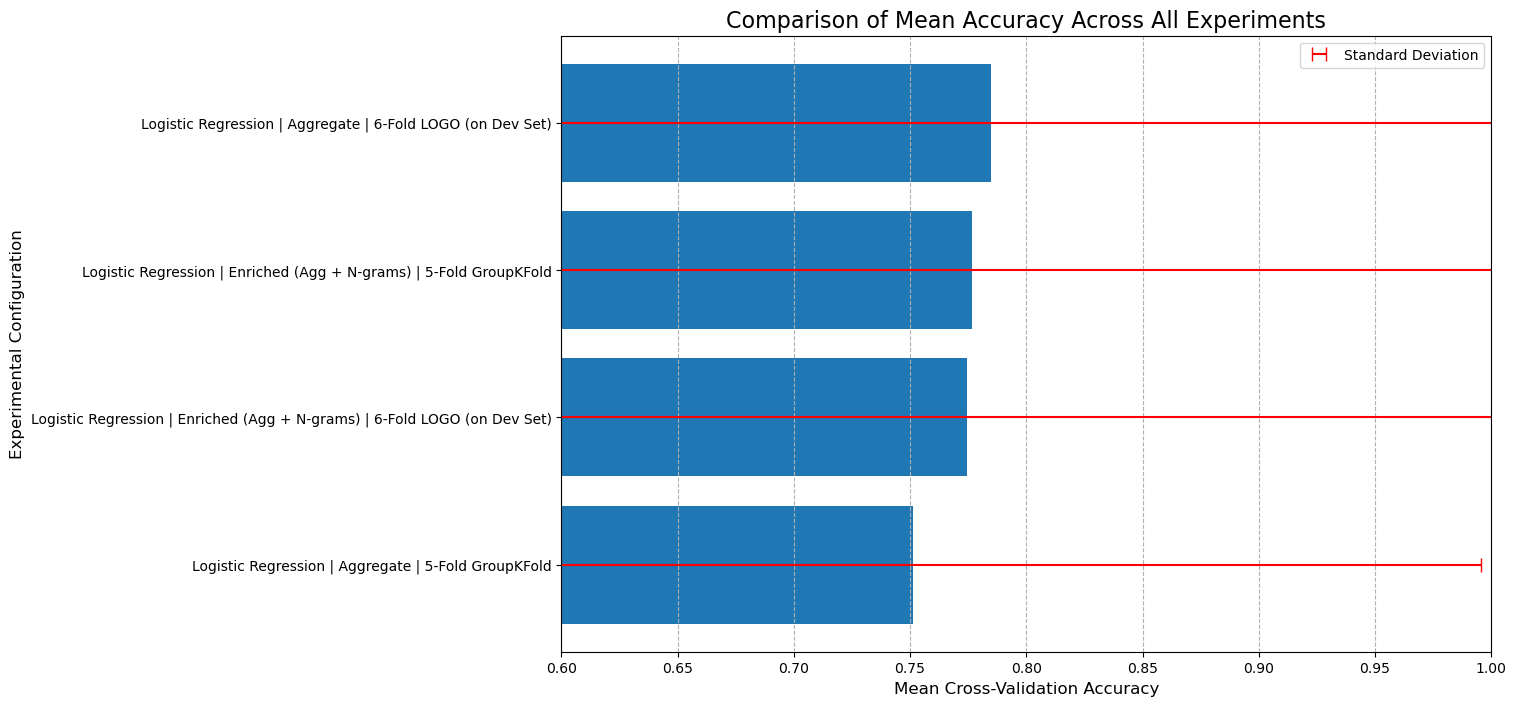

In [ ]:
# --- 2. Visualize the Comparison of All Experimental Runs ---
plt.figure(figsize=(12, 8))
results_df_sorted = results_df.sort_values('mean_accuracy') # Sort for better viewing
plt.barh(results_df_sorted.index, results_df_sorted['mean_accuracy'])

# Add error bars to show the standard deviation (variance) of the scores
plt.errorbar(
    x=results_df_sorted['mean_accuracy'],
    y=results_df_sorted.index,
    xerr=results_df_sorted['std_accuracy'], # Use std_accuracy for error bars
    fmt='none', 
    color='red', 
    capsize=5,
    label='Standard Deviation'
)

plt.title('Comparison of Mean Accuracy Across All Experiments', fontsize=16)
plt.xlabel('Mean Cross-Validation Accuracy', fontsize=12)
plt.ylabel('Experimental Configuration', fontsize=12)
plt.xlim(0.6, 1.0) # Set x-axis limits for better readability
plt.legend()
plt.grid(axis='x', linestyle='--')
plt.show()

### Extension: Live Prediction App

To bring this project to life and demonstrate a practical application of the trained model, I developed a simple real-time prediction application using Python and `tkinter`. This app runs in the background while I play, listens to my live keystrokes, and every few seconds, uses the trained model to update its prediction of which boss I am currently fighting.

The UI is minimal, featuring a "Start/Stop" button and a display that shows the model's confidence (probability) for each of the four bosses, updating in real-time.

# ![Screenshot of the Live Predictor UI]
*(A screenshot of your live predictor application would be placed here.)*


To make this application work, the trained model and its associated pre-processing objects must be saved from this notebook and loaded into the separate Python script. 

In [ ]:
import joblib

# Save the necessary components for the real-time app

# To deploy our best model, we first need to train it on ALL of our data.
# This gives the final model the most information to learn from.
best_model_to_deploy = lr_pipeline
best_model_to_deploy.fit(X_enriched, y_encoded) 

# Bundle all the necessary objects into a single dictionary
deployment_package = {
    'model_pipeline': best_model_to_deploy,
    'ngram_vectorizer': vectorizer,
    'label_encoder': le,
    'agg_feature_columns': X_agg.columns.tolist()
}

# Save the entire package to a single file using joblib
joblib.dump(deployment_package, 'cuphead_predictor.joblib')

print("Deployment package saved to 'cuphead_predictor.joblib'")
print("This file contains the final model and all necessary pre-processors for the live app.")

Deployment package saved to 'cuphead_predictor.joblib'
This file contains the final model and all necessary pre-processors for the live app.


#### Live Prediction Logic: Code Snippets

The live application runs a prediction loop every two seconds. The core logic resides in the `_update_prediction` method, which performs three key steps:

1.  **Real-Time Feature Engineering:** It takes the list of all keystrokes captured so far in the current session and runs them through the *exact same* feature engineering pipeline developed in this notebook. This creates a single-row feature vector that the model can understand.

2.  **Probability Prediction:** The feature vector is passed to the loaded model's `.predict_proba()` method. This doesn't just give the single best guess; it returns an array of probabilities for each of the four classes (e.g., `[0.1, 0.78, 0.02, 0.1]`).

3.  **UI Update:** The application then loops through these probabilities, formats them as percentages, and updates the text of the corresponding labels in the UI, providing an intuitive, real-time view of the model's certainty.

The key code snippets that accomplish this are shown below:

# References


- Minerva University. (2025, October 15). CS156 Session 9 - Metrics and Cross-Validation [Class Lecture]. Forum. https://forum.minerva.edu/app/courses/3678/sections/12801/classes/95069


## Appendices



### Appendix A: UI Design Choices

### Demo Video
#### Data Collection Recording (Old UI - 1h 18 min)

https://www.loom.com/share/29298ba8cc3140d0a84c9be8ac7e7394


#### Data Collection Recording (Latest UI - 8 min)
https://www.loom.com/share/94c7d83c027349d9a0a2fc186096ca72?sid=ae4d6bcb-923f-463b-8225-b8fc977820b4


### UI Design Evolution
The custom-built data logger underwent several design iterations to improve data quality and minimize human error. This iterative process was crucial for building a reliable dataset for analysis.

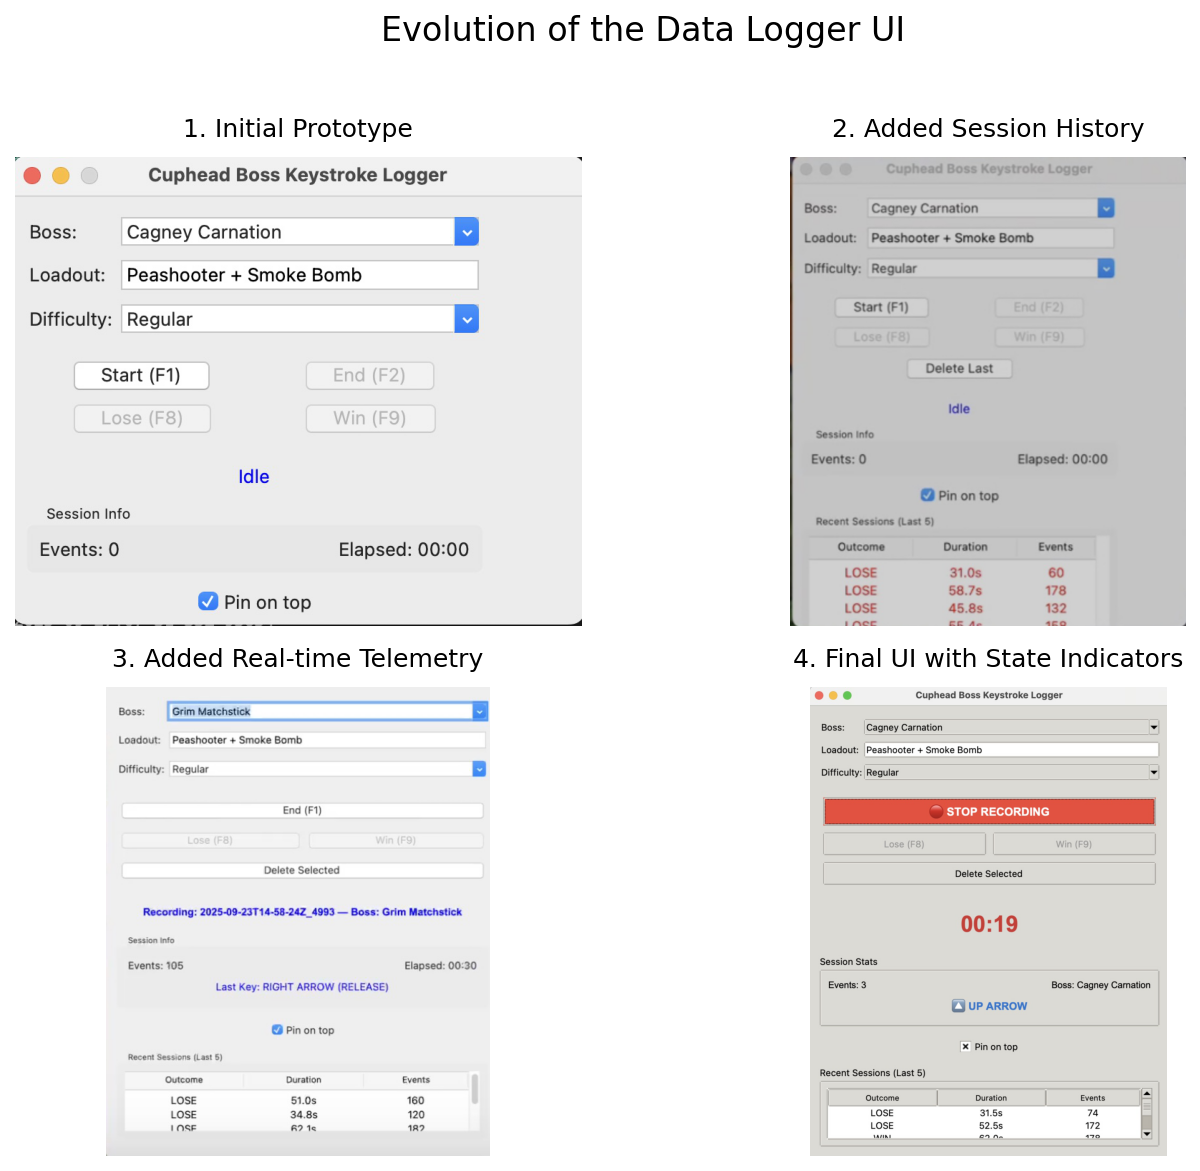
**Figure:** The evolution of the data logger UI, progressing from a basic logging utility to a feature-rich tool incorporating real-time feedback and history tracking for better data governance.

1.  **Initial Prototype:** The first version of the logger was minimalistic, featuring simple buttons and hotkeys. However, it provided no immediate feedback, making it difficult to spot erroneous recordings—such as forgetting to press "Start" until a fight was nearly over.

2.  **Introducing Feedback for Quality Control:** To address this, a "Recent Sessions" panel was added. This view immediately displayed the outcome, duration, and event count of the last five fights. This feature was instrumental in identifying anomalous data at a glance. For instance, a fight logged with a duration of $t < 10$ seconds and a very low event count was clearly an error. The UI allowed such entries to be immediately selected and deleted, preventing contamination of the final dataset.

3.  **Real-time Telemetry:** During initial testing, it became apparent that some keys were not being registered correctly by the listener. To validate the data stream in real time, the UI was updated to display the live elapsed time, total event count, and the most recent key action. This provided immediate confirmation that the logger was functioning as expected.

4.  **Final UI for Reduced Error:** The final design uses strong visual cues to prevent common mistakes. The "Start" button becomes a large, red "STOP RECORDING" button during a session, making the application's state unambiguous. Key telemetry like elapsed time and current keystrokes are given prominence. This user-centric design greatly increased the reliability of the collected data.

After the collection phase, a final manual cleaning step was performed. All fight logs with a duration of less than 10 seconds were cross-checked using the UI and removed to ensure that only valid gameplay sessions were included in the dataset.


### Appendix B: Technical Implementation
# Todo: make this better it's shitty
The core of the logger relies on two key components: a global keyboard listener and a robust data writer.

The `pynput` library was used to create a global keyboard listener that captures events regardless of window focus. The core logic distinguishes between hotkeys (which control the logger) and gameplay keys (which are recorded as data).
# Code Excerpt from app/keyboard_listener.py
# This method handles key press events from the global listener.
def _on_key_press(self, key):
    # Prevent key-repeat events by tracking currently pressed keys
    if key in self._pressed_keys:
        return
    self._pressed_keys.add(key)
    
    # Handle hotkeys (e.g., F1 for starting/stopping)
    if key == Key.f1 and 'start' in self.hotkey_callbacks:
        self.hotkey_callbacks['start']()
    # ... other hotkey logic ...
    
    # Handle gameplay events if an event_callback is defined
    elif self._is_gameplay_key(key) and self.event_callback:
        key_str = self._normalize_key(key)
        self.event_callback('keydown', f"{key_str}")
For each captured gameplay event, a timestamp is calculated relative to the start of the fight. The event is then immediately serialized and written to a JSONL file to prevent any data loss in case of a crash.
# Code Excerpt from app/data_logger.py
# This method logs a single keyboard event to the current session's file.
def log_event(self, event_type: str, key: str):
    if not self.current_session or not self.current_file:
        return
    
    # Calculate elapsed time in milliseconds from the fight's start
    t_ms = int((time.perf_counter() - self.current_session.start_time) * 1000)
    
    event_line = {
        "fight_id": self.current_session.fight_id,
        "event": event_type,
        "key": key,
        "t_ms": t_ms
    }
    
    # Write the event as a JSON line and flush immediately to disk
    self.current_file.write(json.dumps(event_line) + '\n')
    self.current_file.flush()
    self.event_count += 1
### prof suggested to use segmented timeline but it's actually not possible bc all the time data varies..
so instead i usecd mean / variance etc and if not then i can use N/A
i think i can use both model right


ask prof about this.. i'm actually not sure
like saying oh bc "i know that this boss has three phases and other has 2 phases so i splitted the fight into 2 // 3 doesnt that defeat the purspoe or is it considered a good practice?"

orrr i can just sample them?? like firsxt 20 sec idk

### Appendix C: N-gram Mathematical Explanation & Pseudocode

An N-gram is a contiguous sequence of *n* items from a given sample of text or sequence. For a sequence of actions $A = (a_1, a_2, ..., a_T)$, a bigram (2-gram) is a pair $(a_i, a_{i+1})$. The process of creating N-gram features involves two main steps:

1.  **Vocabulary Creation:** The algorithm first scans the entire corpus of action sequences (all 240 fights) to identify all unique N-grams (ex. `'jump dash'`, `'shoot lock'`). The top *k* most frequent N-grams are selected to form the feature "vocabulary," $V = \{ngram_1, ngram_2, ..., ngram_k\}$.

2.  **Vectorization:** For each individual fight, the algorithm creates a feature vector $\mathbf{x}_{ngram}$ of length *k*. Each element $j$ in this vector, $\mathbf{x}_{ngram, j}$, is the count of how many times $ngram_j$ from the vocabulary appears in that fight's action sequence. This is a Term Frequency (TF) representation.